# Libraries

In [2]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [3]:
from train_test.load_train import *
from train_test.load_test import *

In [4]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *


In [5]:
from models.models_1d import *
from dataloaders.dataset_1d import Dataset_1D
from dataloaders.dataset_2d import *
from subprocess import Popen

# Load dictionary

In [6]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/config_files_1d/old/test_1D_ccnn_att_light_3.json"
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'experiment_name': 'pizeo_head_1D', 'run_name': 'ccnn_att_very_light_3', 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models', 'data_dir': '/leonardo_work/IscrC_DL4EO/trials/data/', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'cuda_device': 'cuda:2', 'test_split_p': '2018-01-01', 'all_dataset': True, 'max_ds_elems': 2000, 'normalization': True, 'date_max_norm': '2018-01-01', 'fill_value': 0, 'tr

# Dataset class

In [7]:
ds = Dataset_1D(dict_files)

Norm factors:
{'target_mean': np.float64(298.52083317743796), 'target_std': np.float64(74.0756468500793), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.81300000000007), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.37549999999999), 'lon_std': np.float64(0.43150656619183275), 'weather_mean': <xarray.Dataset> Size: 64B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.601
    tmax         float32 4B 12.35
    tmin         float32 4B 5.036
    tmean        float32 4B 8.692
    prain        float32 4B 2.052
    psnow        float32 4B 0.5488
    et_0         float64 8B 4.873
    r_a          float64 8B 26.37
    snowpack     float64 8B 16.33

In [8]:
from deprecated.old_verision_1d.dataloaders.load_1d_meteo_wtd import ContinuousDataset

In [9]:
alt_ds = ContinuousDataset(dict_files)

Norm factors:
{'target_mean': np.float64(298.52083317743796), 'target_std': np.float64(74.0756468500793), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.81300000000007), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.37549999999999), 'lon_std': np.float64(0.43150656619183275), 'weather_mean': <xarray.Dataset> Size: 64B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.601
    tmax         float32 4B 12.35
    tmin         float32 4B 5.036
    tmean        float32 4B 8.692
    prain        float32 4B 2.052
    psnow        float32 4B 0.5488
    et_0         float64 8B 4.873
    r_a          float64 8B 26.37
    snowpack     float64 8B 16.33

In [58]:
alt_ds.wtd_df

wtd       lon       lat    height  nan_mask  \
date       sensor_id                                                        
2001-01-01 00405910001   1.800000  0.613639 -0.353667 -0.965821      True   
           00408910001   3.981667  0.813198 -0.759672 -0.886174      True   
           00407810001  39.876667  0.374769 -1.221921 -0.702913      True   
           00105910001        NaN  0.807151  0.148287 -1.018794     False   
           00112710001        NaN  0.689774  0.464772 -1.034881     False   
...                           ...       ...       ...       ...       ...   
2023-12-31 00105110001   3.553333  0.517267  0.444808 -1.021212      True   
           00404110001        NaN  0.833452 -0.080484 -0.998107     False   
           00121510001  14.500000  1.203523  0.596678 -0.974594      True   
           00104810001   2.056667  0.915711  0.472337 -1.014218      True   
           00127210005        NaN  0.667861  0.655431 -1.026275     False   

                               h  
date       sensor_id              
2001-01-01 00405910001 -0.207732  
           00408910001  0.714166  
           00407810001  2.418561  
           00105910001       NaN  
           00112710001       NaN  
...                          ...  
2023-12-31 00105110001 -0.893013  
           00404110001       NaN  
           00121510001 -0.483960  
           00104810001 -0.789269  
           00127210005       NaN  

[260400 rows x 6 columns]

In [7]:
ds.wtd_df

wtd       lon       lat    height  nan_mask  \
date       sensor_id                                                        
2001-01-01 00405910001   1.800000  0.613639 -0.353667 -0.965821      True   
           00408910001   3.981667  0.813198 -0.759672 -0.886174      True   
           00407810001  39.876667  0.374769 -1.221921 -0.702913      True   
           00105910001        NaN  0.807151  0.148287 -1.018794     False   
           00112710001        NaN  0.689774  0.464772 -1.034881     False   
...                           ...       ...       ...       ...       ...   
2023-12-31 00105110001   3.553333  0.517267  0.444808 -1.021212      True   
           00404110001        NaN  0.833452 -0.080484 -0.998107     False   
           00121510001  14.500000  1.203523  0.596678 -0.974594      True   
           00104810001   2.056667  0.915711  0.472337 -1.014218      True   
           00127210005        NaN  0.667861  0.655431 -1.026275     False   

                               h  
date       sensor_id              
2001-01-01 00405910001 -0.207732  
           00408910001  0.714166  
           00407810001  2.418561  
           00105910001       NaN  
           00112710001       NaN  
...                          ...  
2023-12-31 00105110001 -0.893013  
           00404110001       NaN  
           00121510001 -0.483960  
           00104810001 -0.789269  
           00127210005       NaN  

[260400 rows x 6 columns]

In [59]:
weather_coords = alt_ds.get_weather_coords()
weather_dtm = alt_ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

In [60]:
(ds.weather_coords_dtm == weather_coords).all()

tensor(True)

In [20]:
ds.control_points_generator(mode = "even", num_lon_point = 200, num_lat_point = 200)

array([[ 1.40047078, -1.73539267,  2.29029632],
       [ 1.40047078, -1.71905981,  2.03037214],
       [ 1.40047078, -1.70272694,  1.86530864],
       ...,
       [-1.55590651,  1.48218182, -0.2940447 ],
       [-1.55590651,  1.49851469, -0.36146632],
       [-1.55590651,  1.51484755, -0.44796762]])

In [68]:
ds[100000][2]

tensor([[[[-3.6057e-01, -3.6259e-01, -3.6589e-01,  ..., -3.7279e-01,
           -3.7165e-01, -3.6777e-01],
          [-3.6675e-01, -3.7007e-01, -3.7279e-01,  ..., -3.7279e-01,
           -3.7293e-01, -3.7021e-01],
          [-3.7293e-01, -3.7409e-01, -3.7351e-01,  ..., -3.7337e-01,
           -3.7309e-01, -3.7223e-01],
          ...,
          [-3.6086e-01, -3.6575e-01, -3.7207e-01,  ..., -3.7151e-01,
           -3.7381e-01, -3.7151e-01],
          [-3.6086e-01, -3.6589e-01, -3.7223e-01,  ..., -3.7309e-01,
           -3.7309e-01, -3.7323e-01],
          [-3.6000e-01, -3.6287e-01, -3.6863e-01,  ..., -3.7351e-01,
           -3.7309e-01, -3.7093e-01]],

         [[ 2.0259e+00,  2.0389e+00,  1.8380e+00,  ...,  1.4695e+00,
            1.4608e+00,  1.6495e+00],
          [ 1.6774e+00,  1.9667e+00,  2.2108e+00,  ...,  1.3813e+00,
            1.3355e+00,  1.4953e+00],
          [ 2.1686e+00,  2.5787e+00,  2.1726e+00,  ...,  1.2903e+00,
            1.1746e+00,  1.3271e+00],
          ...,
     

In [69]:
alt_ds[100000][2]

tensor([[[[-3.6057e-01, -3.6259e-01, -3.6589e-01,  ..., -3.7279e-01,
           -3.7165e-01, -3.6777e-01],
          [-3.6675e-01, -3.7007e-01, -3.7279e-01,  ..., -3.7279e-01,
           -3.7293e-01, -3.7021e-01],
          [-3.7293e-01, -3.7409e-01, -3.7351e-01,  ..., -3.7337e-01,
           -3.7309e-01, -3.7223e-01],
          ...,
          [-3.6086e-01, -3.6575e-01, -3.7207e-01,  ..., -3.7151e-01,
           -3.7381e-01, -3.7151e-01],
          [-3.6086e-01, -3.6589e-01, -3.7223e-01,  ..., -3.7309e-01,
           -3.7309e-01, -3.7323e-01],
          [-3.6000e-01, -3.6287e-01, -3.6863e-01,  ..., -3.7351e-01,
           -3.7309e-01, -3.7093e-01]],

         [[ 2.0259e+00,  2.0389e+00,  1.8380e+00,  ...,  1.4695e+00,
            1.4608e+00,  1.6495e+00],
          [ 1.6774e+00,  1.9667e+00,  2.2108e+00,  ...,  1.3813e+00,
            1.3355e+00,  1.4953e+00],
          [ 2.1686e+00,  2.5787e+00,  2.1726e+00,  ...,  1.2903e+00,
            1.1746e+00,  1.3271e+00],
          ...,
     

In [55]:
(ds[1005][2] == alt_ds[1005][2])

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [76]:
from deprecated.old_verision_1d.models.load_models_1d import SC_CCNN_att
model_alt = SC_CCNN_att(timestep = dict_files["timesteps"],
                 cb_emb_dim = dict_files["cb_emb_dim"],
                 cb_att_h = dict_files["cb_att_h"],
                 cb_fc_layer = dict_files["cb_fc_layer"],
                 cb_fc_neurons = dict_files["cb_fc_neurons"],
                 conv_filters = dict_files["conv_filters"],
                 ccnn_input_filters =  dict_files["ccnn_input_filters"],
                 ccnn_kernel_size =  dict_files["ccnn_kernel_size"],
                 ccnn_n_filters =  dict_files["ccnn_n_filters"],
                 ccnn_n_layers =  dict_files["ccnn_n_layers"])

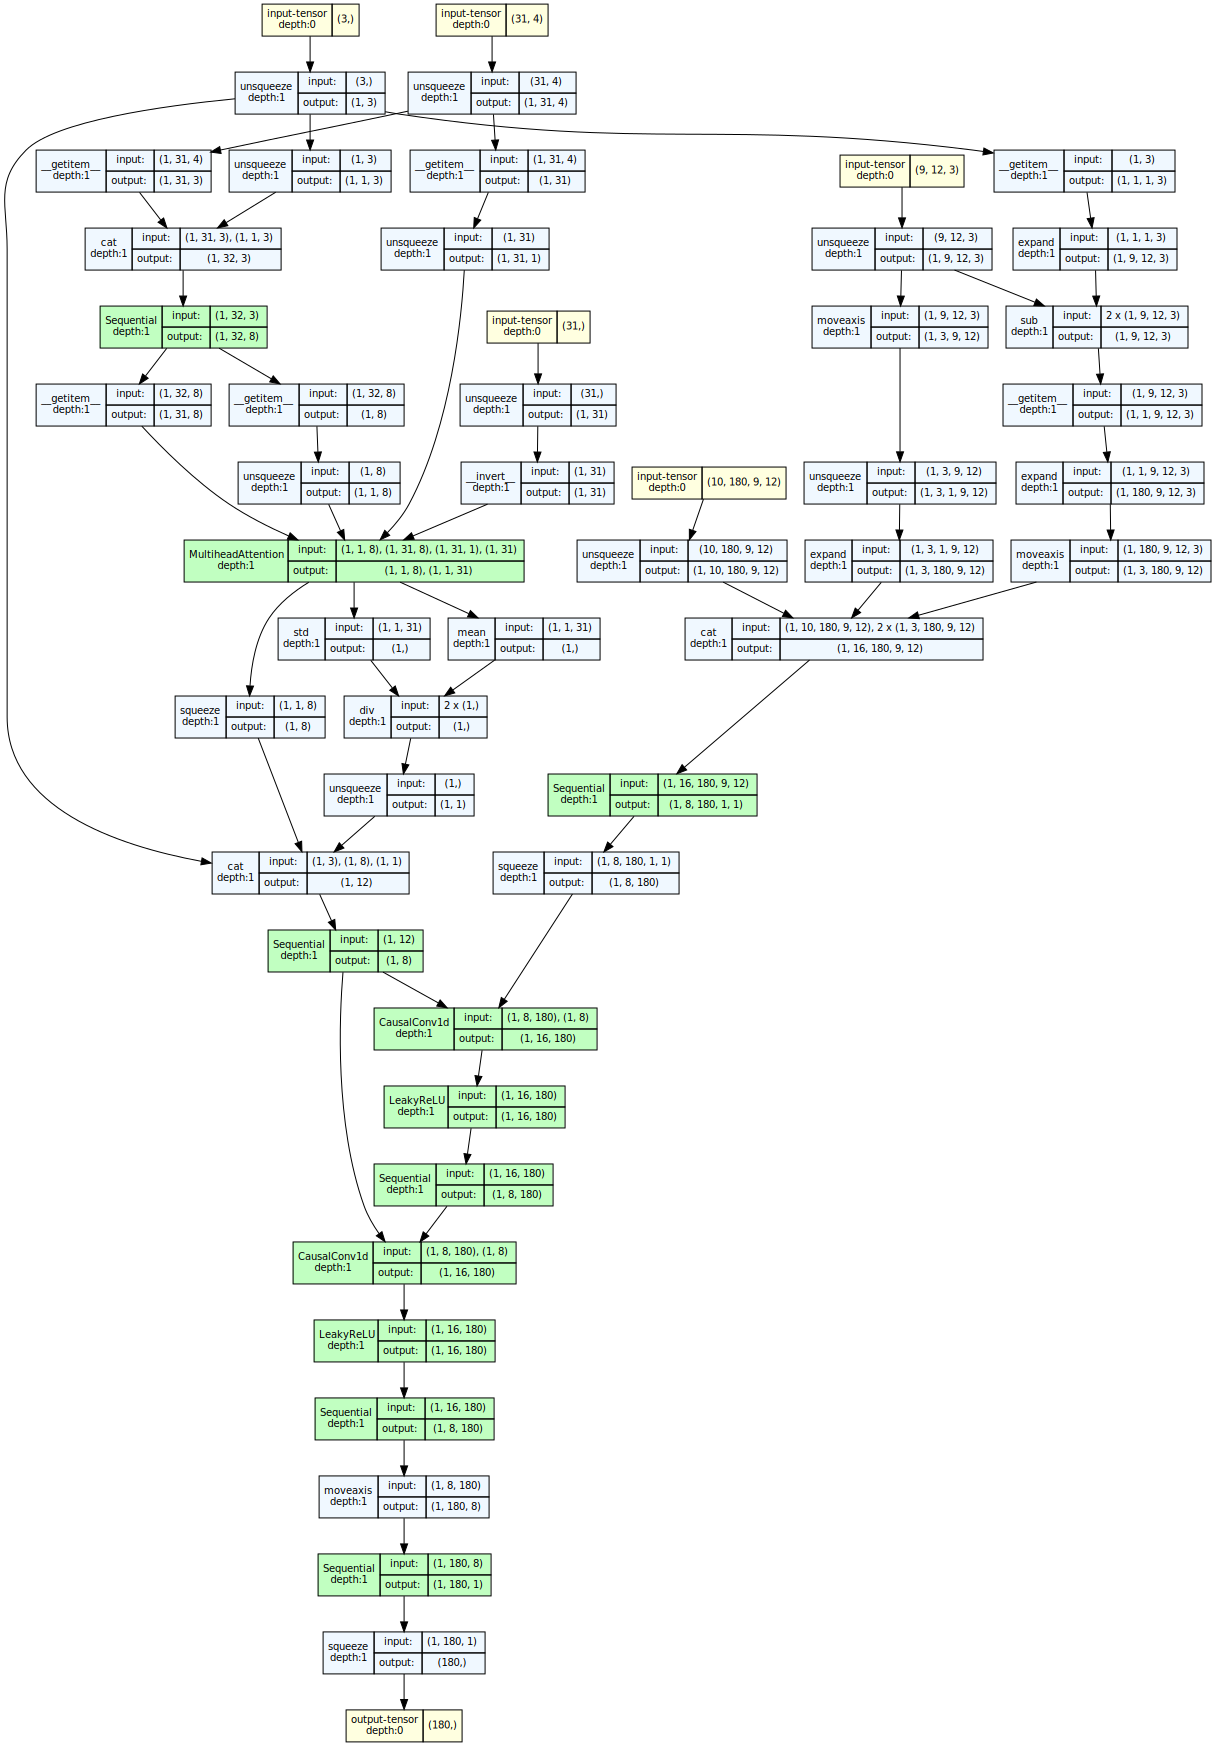

In [77]:
draw_graph(model_alt,
           input_data=(alt_ds[0][0],
                       alt_ds[0][1],
                       [alt_ds[0][2],
                        weather_coords],
                       alt_ds[0][4]),
           depth = 1, device="cpu").visual_graph

In [19]:
ds.get_weather_coords(dtm =True)[:,:,2].detach().mean()

tensor(-0.1063)

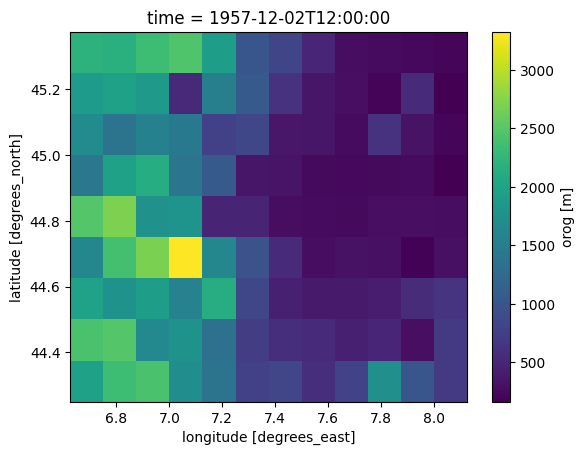

In [18]:
xarray.open_dataset("/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc")["orog"].plot()

In [50]:
ds[0][3]

tensor([    nan,     nan, -0.2077,     nan,     nan, -0.2077,     nan,     nan,
        -0.2077,     nan,     nan, -0.2077,     nan,     nan, -0.2077,     nan,
            nan, -0.2077,     nan,     nan, -0.2077,     nan,     nan, -0.2077,
            nan,     nan, -0.2077,     nan,     nan,     nan, -0.2077,     nan,
            nan, -0.2091,     nan, -0.2091,     nan,     nan,     nan, -0.2104,
            nan,     nan, -0.2104,     nan,     nan, -0.2118,     nan,     nan,
        -0.2118,     nan,     nan, -0.2118,     nan,     nan, -0.2118,     nan,
            nan, -0.2118, -0.2104,     nan,     nan, -0.2104,     nan,     nan,
        -0.2104,     nan,     nan, -0.2050,     nan,     nan, -0.2050,     nan,
            nan, -0.2023,     nan,     nan, -0.2023,     nan,     nan, -0.2050,
            nan,     nan, -0.2050,     nan,     nan, -0.2050,     nan,     nan,
            nan, -0.2064,     nan,     nan, -0.2077,     nan,     nan, -0.2077,
            nan,     nan, -0.2077,     n

In [8]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 254820


In [8]:
len(ds.dtm_roi.y.values)

1146

In [9]:
i = 100
ds.dtm_roi.x.values[i] - ds.dtm_roi.x.values[i - 1]

np.float64(0.0008333333333325754)

In [10]:
i = 1
ds.dtm_roi.y.values[i] - ds.dtm_roi.y.values[i - 1]

np.float64(-0.0008333333333325754)

In [11]:
step = 0.0009

In [ ]:
import geopy.distance

In [12]:
spatial_resolution_meteo =  geopy.distance.geodesic((ds.dtm_roi.y.values[0],
                               ds.dtm_roi.x.values[0]),
                               (ds.dtm_roi.y.values[0],
                                ds.dtm_roi.x.values[0]+step)).km
print("Resolution in km: ", round(spatial_resolution_meteo, 3))

Resolution in km:  0.071


In [13]:
# Compute the resolution in km
spatial_resolution_meteo =  geopy.distance.geodesic((ds.dtm_roi.y.values[0],
                               ds.dtm_roi.x.values[0]),
                               (ds.dtm_roi.y.values[1],
                                ds.dtm_roi.x.values[0])).km
print("Resolution in km: ", round(spatial_resolution_meteo, 3))

Resolution in km:  0.093


In [14]:
step = 0.01#0.0009
num_cpoints = 5
bbox = [ds.dtm_roi.x.min().values,
                    ds.dtm_roi.x.max().values,
                    ds.dtm_roi.y.min().values,
                    ds.dtm_roi.y.max().values]
margin = 1.2 * step
x = np.random.uniform(low=bbox[0]+margin, high=bbox[1]-margin, size=num_cpoints)
y = np.random.uniform(low=bbox[2]+margin, high=bbox[3]-margin, size=num_cpoints)

x_right = x + step
x_two_right = x + 2*step

x_left = x - step
x_two_left = x - 2*step

y_up = y + step
y_two_up = y + 2*step

y_down = y - step
y_two_down = y - 2*step

dtm_xy = []
dtm_xy_right = []
dtm_xy_two_right = []
dtm_xy_left = []
dtm_xy_two_left = []
dtm_xy_up = []
dtm_xy_two_up = []
dtm_xy_down = []
dtm_xy_two_down = []

for i in range(num_cpoints):
    dtm_xy.append(ds.dtm_roi.sel(x = x[i], y = y[i],
                    method = "nearest").values)
    
    dtm_xy_right.append(ds.dtm_roi.sel(x = x_right[i], y = y[i],
                    method = "nearest").values)
    dtm_xy_two_right.append(ds.dtm_roi.sel(x = x_two_right[i], y = y[i],
                    method = "nearest").values)
    
    dtm_xy_left.append(ds.dtm_roi.sel(x = x_left[i], y = y[i],
                    method = "nearest").values)
    dtm_xy_two_left.append(ds.dtm_roi.sel(x = x_two_left[i], y = y[i],
                    method = "nearest").values)
    
    dtm_xy_up.append(ds.dtm_roi.sel(x = x[i], y = y_up[i],
                    method = "nearest").values)
    dtm_xy_two_up.append(ds.dtm_roi.sel(x = x[i], y = y_two_up[i],
                    method = "nearest").values)
    
    dtm_xy_down.append(ds.dtm_roi.sel(x = x[i], y = y_down[i],
                    method = "nearest").values)
    dtm_xy_two_down.append(ds.dtm_roi.sel(x = x[i], y = y_two_down[i],
                    method = "nearest").values)

    
dtm_xy = np.array(dtm_xy)

dtm_xy_right = np.array(dtm_xy_right)
dtm_xy_two_right = np.array(dtm_xy_two_right)

dtm_xy_left = np.array(dtm_xy_left)
dtm_xy_two_left = np.array(dtm_xy_two_left)

dtm_xy_up = np.array(dtm_xy_up)
dtm_xy_two_up = np.array(dtm_xy_two_up)

dtm_xy_down = np.array(dtm_xy_down)
dtm_xy_two_down = np.array(dtm_xy_two_down)

coords = np.concat([np.expand_dims(y, 1), np.expand_dims(x, 1), dtm_xy], axis=-1)

coords_right = np.concat([np.expand_dims(y, 1), np.expand_dims(x_right, 1), dtm_xy_right], axis=-1)
coords_two_right = np.concat([np.expand_dims(y, 1), np.expand_dims(x_two_right, 1), dtm_xy_two_right], axis=-1)

coords_left = np.concat([np.expand_dims(y, 1), np.expand_dims(x_left, 1), dtm_xy_left], axis=-1)
coords_two_left = np.concat([np.expand_dims(y, 1), np.expand_dims(x_two_left, 1), dtm_xy_two_left], axis=-1)

coords_up = np.concat([np.expand_dims(y_up, 1), np.expand_dims(x, 1), dtm_xy_up], axis=-1)
coords_two_up = np.concat([np.expand_dims(y_two_up, 1), np.expand_dims(x, 1), dtm_xy_two_up], axis=-1)

coords_down = np.concat([np.expand_dims(y_down, 1), np.expand_dims(x, 1), dtm_xy_down], axis=-1)
coords_two_down = np.concat([np.expand_dims(y_two_down, 1), np.expand_dims(x, 1), dtm_xy_two_down], axis=-1)

all_coords = np.stack([coords, coords_right, coords_left, coords_up, coords_down,
    coords_two_right, coords_two_left, coords_two_up, coords_two_down], axis=-1)

In [15]:
all_coords.shape

(5, 3, 9)

In [16]:
torch.repeat_interleave(torch.tensor([[0,0,0],
                                      [1,1,1]]), 2, dim=0)

tensor([[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        [1, 1, 1]])

In [17]:
all_coords[0,:,0].shape

(3,)

In [18]:
z_cpoints = np.stack([ds.control_points_generator(
                                 mode = "urandom+nb",
                                 num_lon_point = 5,
                                 num_lat_point = 5,
                                 step = 0.0009) for i in range(10)], axis = 0)

z_cpoints = torch.tensor(z_cpoints, requires_grad=True).to(torch.float32)
                        
#z_cpoints = z_cpoints.moveaxis(-1, 2).flatten(start_dim=0, end_dim=2) 

In [19]:
z_cpoints.shape

torch.Size([10, 5, 3, 9])

In [20]:
prova = torch.tensor([[[7,0,9],
               [5,5,5]],
              [[1,1,3],
               [1,4,1]]])

print(prova.shape)
print("moved ax", prova.moveaxis(-1, 1))
resh = prova.moveaxis(-1, 1).flatten(start_dim=0, end_dim=1)
print(resh.shape)
print(resh)



torch.Size([2, 2, 3])
moved ax tensor([[[7, 5],
         [0, 5],
         [9, 5]],

        [[1, 1],
         [1, 4],
         [3, 1]]])
torch.Size([6, 2])
tensor([[7, 5],
        [0, 5],
        [9, 5],
        [1, 1],
        [1, 4],
        [3, 1]])


In [21]:
resh.reshape(2,3,2)

tensor([[[7, 5],
         [0, 5],
         [9, 5]],

        [[1, 1],
         [1, 4],
         [3, 1]]])

In [22]:
from shapely.geometry import Point

point_name = np.arange(0,45)

geom_point = [Point(all_coords[i,1,j],all_coords[i,0,j],all_coords[i,2,j]) for i in range(5) for j in range(9)]
geom_point = gpd.GeoDataFrame({"Municipality": point_name}, geometry = geom_point)

In [23]:
main_path = "/leonardo_work/IscrC_DL4EO/trials"
data_path = f"{main_path}/data"

piemonte_shp = gpd.read_file(f"{data_path}/shapefile/piemonte_admin_boundaries.shp", engine='pyogrio')
piemonte_shp = piemonte_shp.to_crs('epsg:4326')

# remove the small enclaved Cuneo area inside Torino province
piemonte_shp = piemonte_shp[:-1]

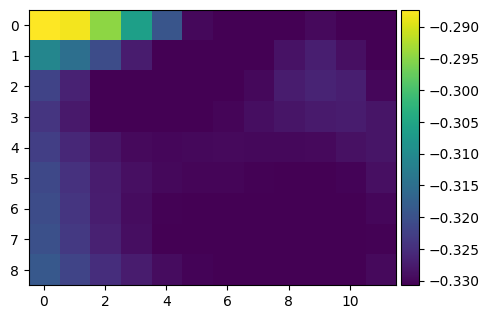

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize = (5, 5))
prova = ax.imshow(ds.weather_xr["prain"][0].values)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(prova, cax = cax)

plt.tight_layout()

/leonardo_scratch/fast/IscrC_DL4EO/my_venv_fast/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


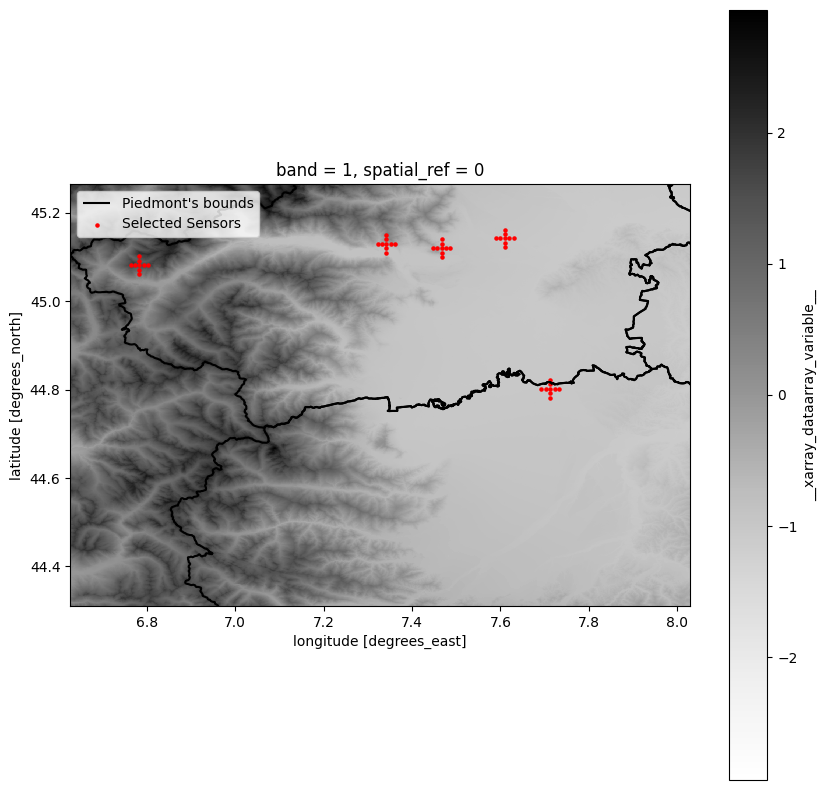

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
ds.dtm_roi.plot(ax = ax, cmap = "Greys")
piemonte_shp.boundary.plot(ax = ax, color = "black", label = "Piedmont's bounds")
geom_point.plot(ax = ax, markersize = 20, marker = ".", color = 'red',label = "Selected Sensors")
ax.legend()
plt.show()

# Model 

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [13]:
if dict_files["model"] == "SC_LSTM_idw":
    print("model idw")
    model = SC_LSTM_idw(timestep = dict_files["timesteps"],
                 cb_fc_layer = dict_files["cb_fc_layer"],
                 cb_fc_neurons = dict_files["cb_fc_neurons"],
                 conv_filters = dict_files["conv_filters"],
                 lstm_layer = dict_files["lstm_layer"],
                 lstm_input_units = dict_files["lstm_input_units"],
                 lstm_units = dict_files["lstm_units"]
                 ).to(device)

elif dict_files["model"] == "SC_LSTM_att":
    print("model att")
    model = SC_LSTM_att(timestep = dict_files["timesteps"],
                 cb_emb_dim = dict_files["cb_emb_dim"],
                 cb_att_h = dict_files["cb_att_h"],
                 cb_fc_layer = dict_files["cb_fc_layer"],
                 cb_fc_neurons = dict_files["cb_fc_neurons"],
                 conv_filters = dict_files["conv_filters"],
                 lstm_layer = dict_files["lstm_layer"],
                 lstm_input_units = dict_files["lstm_input_units"],
                 lstm_units = dict_files["lstm_units"]
                 ).to(device)
    
elif dict_files["model"] == "SC_CCNN_att":
    print("model causal cnn att")
    model = SC_CCNN_att(timestep = dict_files["timesteps"],
                 cb_emb_dim = dict_files["cb_emb_dim"],
                 cb_att_h = dict_files["cb_att_h"],
                 cb_fc_layer = dict_files["cb_fc_layer"],
                 cb_fc_neurons = dict_files["cb_fc_neurons"],
                 conv_filters = dict_files["conv_filters"],
                 ccnn_input_filters =  dict_files["ccnn_input_filters"],
                 ccnn_kernel_size =  dict_files["ccnn_kernel_size"],
                 ccnn_n_filters =  dict_files["ccnn_n_filters"],
                 ccnn_n_layers =  2,
                 ).to(device)


model causal cnn att


In [14]:
model_path = "/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models/model_20250120_163649.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

SC_CCNN_att(
  (cb_emb): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (multihead_att): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (cb_fc): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv3d_stack): Sequential(
    (0): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (7): BatchNorm3

In [23]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  9265


In [24]:
model

SC_CCNN_att(
  (cb_emb): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (multihead_att): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (cb_fc): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv3d_stack): Sequential(
    (0): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (7): BatchNorm3

In [25]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
weather_coords_batch = weather_coords.unsqueeze(0).expand(1, -1, -1, -1).requires_grad_()

x = ds[2000][0][None,:,:].expand(1 , -1, -1).requires_grad_()
z = ds[2000][1][None, :].expand(1, -1).requires_grad_()
w_0 = ds[2000][2].unsqueeze(0).expand(1, -1, -1, -1, -1).requires_grad_()
w_1 = weather_coords_batch

x_mask = ds[2000][4][None, :].expand(1, -1)

target_pred = model(x = x,
      z = z,
      w = [w_0, w_1],
      x_mask = x_mask)

target_pred.shape

TypeError: ContinuousDataset.get_avail_target_data() takes 2 positional arguments but 3 were given

In [13]:
len(target_pred.shape)

1

# Sketch

In [12]:
y = torch.zeros([8,16,9,180])
h = torch.zeros([8,16,9,2])
y.shape

torch.Size([8, 16, 9, 180])

In [14]:
h[:,:,0,0].shape

torch.Size([8, 16])

In [22]:
def disc_physics_loss(y_hat,
                      y_hat_two_right, y_hat_two_left, y_hat_two_up, y_hat_two_down,
                      k_lat_up, k_lat_down,
                      k_lon_right, k_lon_left,
                      step = torch.tensor([1]),
                      g =  torch.tensor([0]), S_y =  torch.tensor([1])):
    
    
    #first_lon_diff = - k_lon * fdiff_fprime_soa(y_hat_right, y_hat_left, delta = step)
    first_lon_diff_right = - k_lon_right * fdiff_fprime_soa(y_hat_two_right, y_hat, delta = step)
    first_lon_diff_left = - k_lon_left * fdiff_fprime_soa(y_hat, y_hat_two_left, delta = step)
    
    #first_lat_diff = - k_lat * fdiff_fprime_soa(y_hat_up, y_hat_down, delta = step)
    first_lat_diff_up = - k_lat_up * fdiff_fprime_soa(y_hat_two_up, y_hat, delta = step)
    first_lat_diff_down = - k_lat_down * fdiff_fprime_soa(y_hat, y_hat_two_down, delta = step)

    second_lon_diff = fdiff_fprime_soa(first_lon_diff_right, first_lon_diff_left, delta = step)
    second_lat_diff = fdiff_fprime_soa(first_lat_diff_up, first_lat_diff_down, delta = step)

    first_time_diff = S_y * (y_hat[:,:,1:] - y_hat[:,:,:-1])
    print(first_time_diff.shape)
    
    residuals = first_time_diff + second_lon_diff[:,:,:-1] + second_lat_diff[:,:,:-1] + g
    loss_physics = torch.sum(residuals**2)
    return loss_physics

In [23]:
disc_physics_loss(y[:,:,0,:], y[:,:,0,:], y[:,:,0,:], y[:,:,0,:], y[:,:,0,:],
                  h[:,:,1,1].unsqueeze(-1).expand(-1,-1,180), h[:,:,1,1].unsqueeze(-1).expand(-1,-1,180), h[:,:,1,1].unsqueeze(-1).expand(-1,-1,180), h[:,:,1,1].unsqueeze(-1).expand(-1,-1,180))

torch.Size([8, 16, 179])


tensor(0.)

In [17]:
from dataloaders.load_dataset import *

In [18]:
dict_files["dataset_type"] = "1d"

In [19]:
train_loader, test_loader = get_dataloader(ds, dict_files)

Traing size: 192478 - 2017-12-31 00:00:00, Test size: 62342 - 2023-07-04 00:00:00


In [14]:
ds[0]

[tensor([[-0.3537,  0.6136, -0.9658, -0.2077],
         [-0.7597,  0.8132, -0.8862,  0.7142],
         [-1.2219,  0.3748, -0.7029,  2.4186],
         [ 0.1483,  0.8072, -1.0188,  0.0000],
         [ 0.4648,  0.6898, -1.0349,  0.0000],
         [ 0.2368,  0.2765, -0.9950,  0.0000],
         [-0.1250,  0.7241, -0.9973,  0.0000],
         [-0.9135,  0.3633, -0.7772,  0.0000],
         [ 0.7374,  0.6490, -1.0053,  0.0000],
         [ 0.0522, -0.1553, -0.8669,  0.0000],
         [-0.2535, -0.0835, -0.9128,  0.0000],
         [-0.9437,  0.2649, -0.7349,  0.0000],
         [-0.5176,  0.6418, -0.9299,  0.0000],
         [ 0.3484,  1.0944, -1.0181,  0.0000],
         [-0.3848,  1.0897, -0.9726,  0.0000],
         [-0.7525,  0.4624, -0.8527,  0.0000],
         [ 0.2322,  0.7215, -1.0282,  0.0000],
         [-0.1432,  0.3564, -1.0036,  0.0000],
         [ 0.8703,  0.4616, -0.9582,  0.0000],
         [ 0.8216,  0.7954, -1.0433,  0.0000],
         [ 0.6299,  0.3684, -0.9801,  0.0000],
         [ 0.

In [27]:
a = "ddd"
b = "123"
c = 'model_{}_{}.pt'.format(a, b)
c

'model_ddd_123.pt'

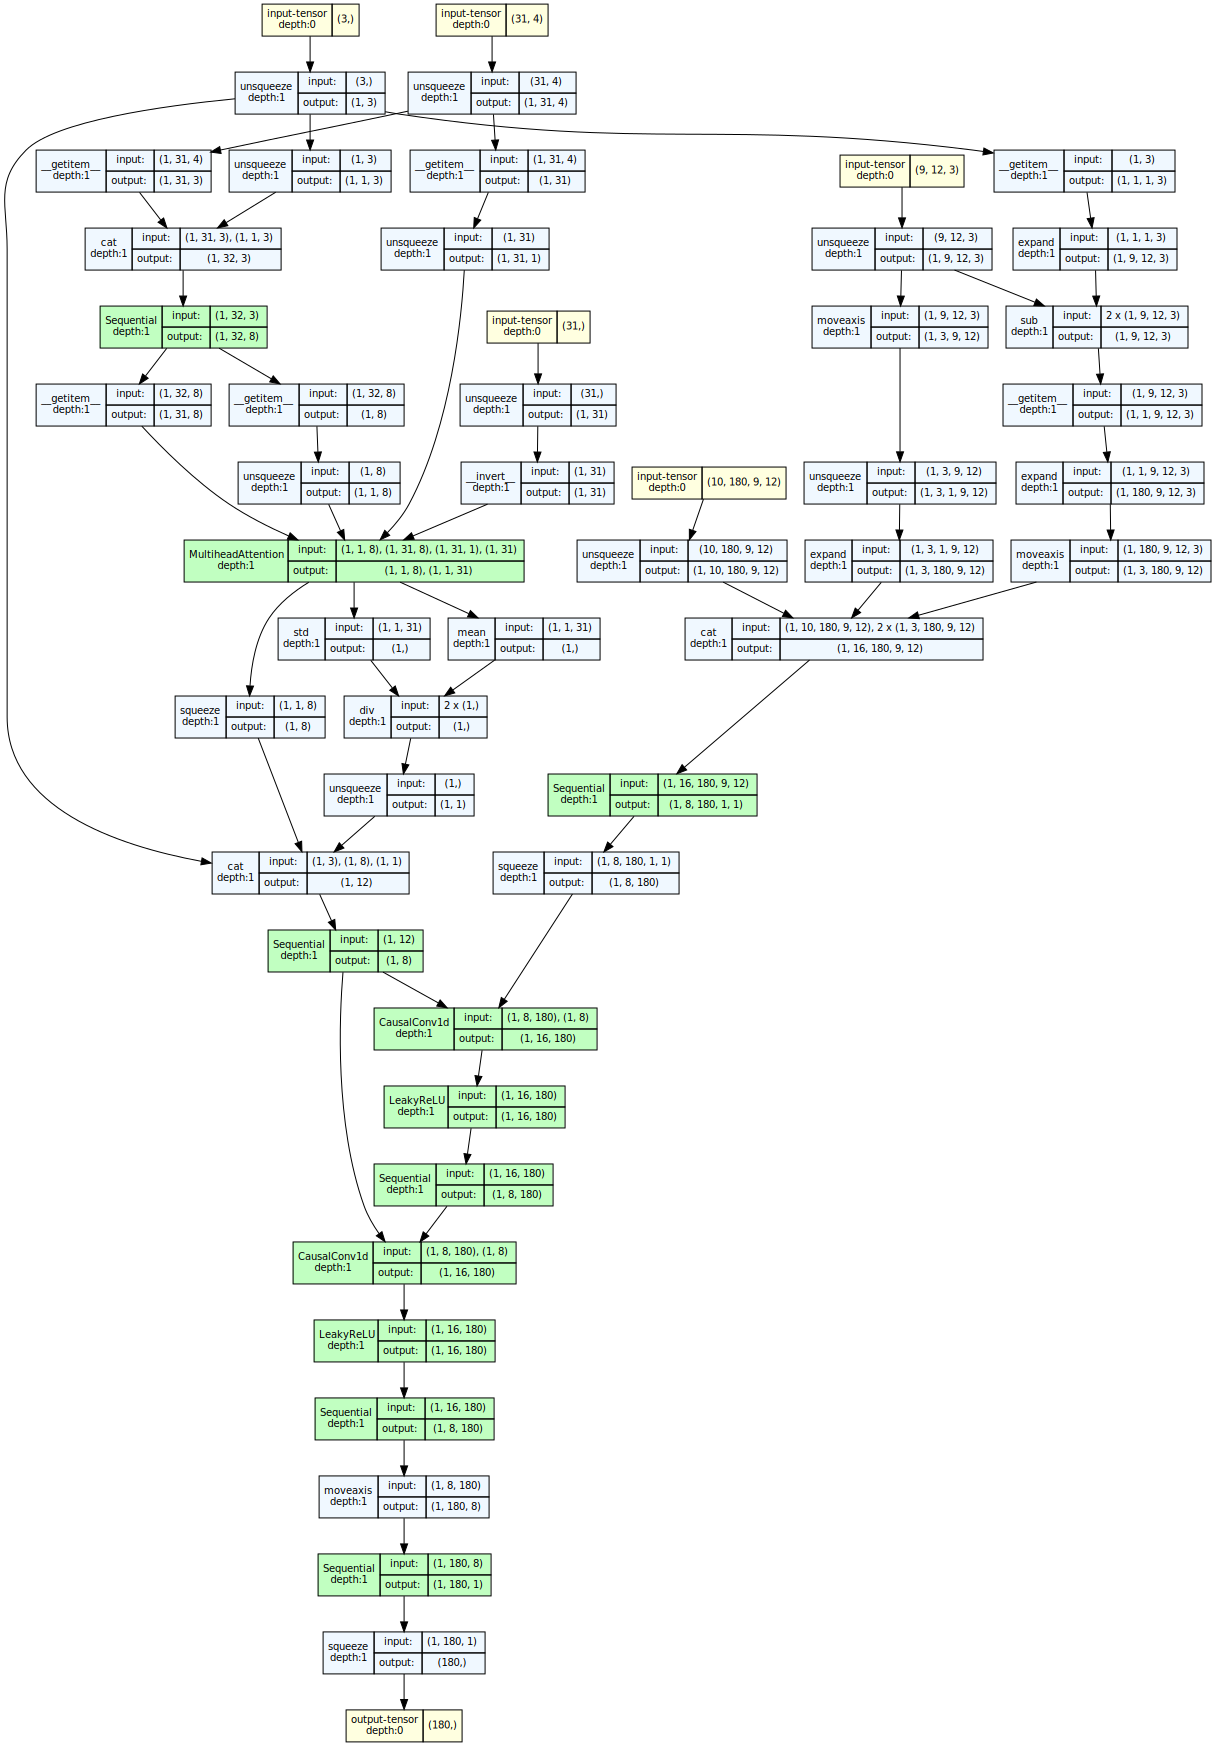

In [22]:
# [X, Z, W, Y, X_mask, Y_mask]
draw_graph(model, input_data=(ds[0][0], ds[0][1], [ds[0][2], ds.get_weather_coords(dtm = True)], ds[0][4]), depth = 1, device=device).visual_graph

In [20]:
from models.load_models_2d_refactoring import *
model_2d = Discrete2DConvLSTM(180)
dict_files["test_split_p"] = 0.2

In [21]:
ds_2d = DiscreteDataset(dict_files)

Rasterizing wtd dataframe...
Rasterized wtd dataframe.
Creating piezometric head dataset...
Piezometric head dataset created.
Value mean: 295.29437255859375
Value std: 72.11563110351562
Normalization: ON


In [22]:
dtm_2d = torch.from_numpy(ds_2d.dtm_roi_downsampled.values)

In [23]:
X = (ds_2d[0][0].unsqueeze(0), dtm_2d, ds_2d[0][1].unsqueeze(0))

In [24]:
model_2d(X)

tensor([[[[[ 0.1785, -0.3973, -0.5154,  ...,  0.1433,  0.1009,  0.0661],
           [ 0.7606,  0.0847,  0.4823,  ...,  0.0636,  0.2275, -0.0395],
           [ 0.7821,  0.0046, -0.4415,  ...,  0.0145,  0.1622, -0.1030],
           ...,
           [ 0.6202,  0.0376,  0.0274,  ...,  0.1530,  0.3227, -0.0436],
           [ 0.4009,  0.0036,  0.0125,  ...,  0.0573,  0.1070, -0.0234],
           [ 0.4461,  0.1169,  0.3267,  ...,  0.6242,  0.6443,  0.1840]],

          [[ 0.2967, -0.7823, -0.6140,  ...,  0.2027,  0.1320,  0.1077],
           [ 0.7538,  0.0915,  0.2929,  ...,  0.1416,  0.2888, -0.0884],
           [ 0.8513, -0.0403, -0.6477,  ...,  0.0768,  0.2367, -0.1466],
           ...,
           [ 0.6443,  0.0257,  0.0525,  ...,  0.2504,  0.2758, -0.0704],
           [ 0.5693,  0.0086,  0.0294,  ...,  0.3182,  0.2237, -0.0271],
           [ 0.5282,  0.0672,  0.2248,  ...,  0.5917,  0.4035,  0.1348]],

          [[ 0.3089, -0.8220, -0.5775,  ...,  0.2473,  0.1591,  0.1251],
           [ 0.

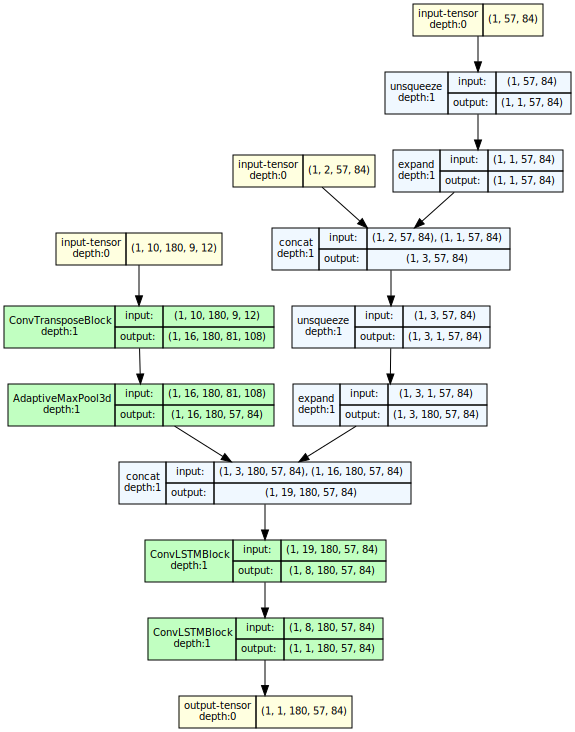

In [25]:
draw_graph(model_2d, input_data=[X], device=device, depth = 1).visual_graph

In [74]:
from loss.losses_1d import *

In [ ]:
feedforward_dloss_pdeloss(model, (x = x, z, w, x_mask),
                        groundtruth,
                        g,
                        k_lat,
                        k_lon,
                        S_y,
                        num_cpoints,
                        ds,
                        device,
                        coeff_loss_data,
                        coeff_loss_pde,
                        loss_prefix_name,
                        require_grad = True)

In [73]:
cpoint_generation(minX = ds.dtm_roi.x.min().values, maxX = ds.dtm_roi.x.max().values,
                                                minY = ds.dtm_roi.y.min().values, maxY = ds.dtm_roi.y.max().values,
                                                dtm = (ds.dtm_roi *ds.norm_factors["dtm_std"]) + ds.norm_factors["dtm_mean"],
                                                mode = "urandom",
                                                num_lon_point = 1,
                                                num_lat_point = 1).shape

(1, 3)

In [9]:
x_rand = np.random.uniform(low=0.0, high=1.0, size=4)
print(x_rand)
y_rand = np.random.uniform(low=1., high=2., size=4)
print(y_rand)

X, Y = np.meshgrid(x_rand, y_rand)
cpoints = np.stack([x_rand, y_rand], axis = -1)
cpoints.shape

[0.64666462 0.56151517 0.07452536 0.0900295 ]
[1.92180981 1.27276869 1.30072891 1.41829028]


(4, 2)

In [18]:
cpoints.shape

(12, 2)

In [ ]:
x = np.linspace(minX, maxX, num_lon_point)
        y = np.linspace(minY, maxY, num_lat_point)[::-1]
        # create the mesh based on these arrays
        X, Y = np.meshgrid(x, y)

In [38]:
prova_keys = torch.tensor([[[[0], [1], [2]],
                         [[0], [1], [2]],
                         [[0], [1], [2]],
                         [[0], [1], [2]]],
                           [[[0], [1], [2]],
                         [[0], [1], [2]],
                         [[0], [1], [2]],
                         [[0], [1], [2]]]]).to(torch.float32)

print(prova_keys.shape)
print("flattened keys", prova_keys.flatten(1, -2).shape)

prova_queries = torch.tensor([[[[0], [1]],
                         [[0], [1]]],
                              [[[0], [1]],
                         [[0], [1]]]]).to(torch.float32)

print(prova_queries.shape)
print("flattened queries", prova_queries.flatten(1, -2).shape)

torch.Size([2, 4, 3, 1])
flattened keys torch.Size([2, 12, 1])
torch.Size([2, 2, 2, 1])
flattened queries torch.Size([2, 4, 1])


In [39]:
multihead_attn = nn.MultiheadAttention(embed_dim = 1, num_heads = 1, batch_first=True)
attn_output, attn_output_weights = multihead_attn(prova_queries.flatten(1, -2),
                                                  prova_keys.flatten(1, -2),
                                                  prova_keys.flatten(1, -2))

In [40]:
attn_output.shape

torch.Size([2, 4, 1])

# PDE loss sketch

In [14]:
import deepxde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


No backend selected.
Finding available backend...
Found pytorch
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [51]:
x = torch.tensor([[1.,2.,3.],
                  [1.,2.,4.]], requires_grad=True)
print("X:", x)
print(x.shape)

y = torch.ones_like(x)
y[:, 0] = x[:, 0] + x[:, 1] + x[:, 2] # gradients = 1 + 1 + 1 
y[:, 1] = - x[:, 0] - x[:, 1] - x[:, 2] # gradients = - 1 - 1 - 1
y[:, 2] = 2*x[:, 0] + 2*x[:, 1] + x[:, 2]**2 # gradients = 2 + 2 + 2x

print("Y:", y)
print(y.shape)

grad_mask = torch.tensor([[1,1,1],
                  [0,1,0]])

# Autograd: Compute and return the sum of gradients of outputs with respect to the inputs.
deepxde.config.set_default_autodiff("forward")
print("\nGradients - Autograd: \n", deepxde.gradients.gradients.jacobian(y.unsqueeze(1),
                                                                         x.unsqueeze(1), j = 1))

X: tensor([[1., 2., 3.],
        [1., 2., 4.]], requires_grad=True)
torch.Size([2, 3])
Y: tensor([[ 6., -6., 15.],
        [ 7., -7., 22.]], grad_fn=<CopySlices>)
torch.Size([2, 3])
Set the default automatic differentiation to forward mode.


ValueError: j=1 is not valid.

In [28]:
x = torch.tensor([[1.,2.,3.],
                  [1.,2.,4.]], requires_grad=True)
print("X:", x)
print(x.shape)

y = torch.ones_like(x)
y[:, 0] = x[:, 0] + x[:, 1] + x[:, 2] # gradients = 1 + 1 + 1 
y[:, 1] = - x[:, 0] - x[:, 1] - x[:, 2] # gradients = - 1 - 1 - 1
y[:, 2] = 2*x[:, 0] + 2*x[:, 1] + x[:, 2]**2 # gradients = 2 + 2 + 2x

print("Y:", y)
print(y.shape)

grad_mask = torch.tensor([[1,1,1],
                  [0,1,0]])


# Autograd: Compute and return the sum of gradients of outputs with respect to the inputs.
print("\nGradients - Autograd: \n", torch.autograd.grad(y, x,
                                                        grad_outputs= torch.ones_like(x))) # grad_outputs should be a sequence of length matching output containing the “vector” in vector-Jacobian product (v^T@J)

X: tensor([[1., 2., 3.],
        [1., 2., 4.]], requires_grad=True)
torch.Size([2, 3])
Y: tensor([[ 6., -6., 15.],
        [ 7., -7., 22.]], grad_fn=<CopySlices>)
torch.Size([2, 3])

Gradients - Autograd: 
 (tensor([[2., 2., 6.],
        [2., 2., 8.]]),)


In [22]:
grad_mask.shape

torch.Size([3, 4])

In [24]:
torch.eye(y.shape[-1]).shape

torch.Size([4, 4])

In [28]:
x = torch.tensor([[1.,2.,3.],
                  [1.,2.,4.]], requires_grad=True)
print("X:", x)
print(x.shape)

y = torch.ones_like(x)
y[:, 0] = x[:, 0] + x[:, 1] + x[:, 2] # gradients = 1 + 1 + 1 
y[:, 1] = - x[:, 0] - x[:, 1] - x[:, 2] # gradients = - 1 - 1 - 1
y[:, 2] = 2*x[:, 0] + 2*x[:, 1] + x[:, 2]**2 # gradients = 2 + 2 + 2x

print("Y:", y)
print(y.shape)

grad_mask = torch.tensor([[1,0,0],
                  [0,0,1]]) # only the derivatives for x_1


print("\nGradients - Autograd Masked: \n", torch.autograd.grad(y, x,
                                                        grad_outputs= grad_mask,
                                                        retain_graph=True))

# each element of output is the sum of the gradients of the input in the same poisition wrt the output 


#print("\nGradients - Backward: \n", y.backward(torch.ones_like(y)))

X: tensor([[1., 2., 3.],
        [1., 2., 4.]], requires_grad=True)
torch.Size([2, 3])
Y: tensor([[ 6., -6., 15.],
        [ 7., -7., 22.]], grad_fn=<CopySlices>)
torch.Size([2, 3])

Gradients - Autograd Masked: 
 (tensor([[1., 1., 1.],
        [2., 2., 8.]]),)


In [27]:
x = torch.tensor([1.,2.,3.], requires_grad=True)
print("X:", x)
print(x.shape)

y = torch.ones(4)

y[0] = x.sum() # gradients = 1 + 1 + 1 
y[1] = (-1*x).sum() # gradients = - 1 - 1 - 1
y[2] = (x**2).sum()
y[3] = (x**3).sum()
#y[:, 2] = 2*x[:, 0] + 2*x[:, 1] + x[:, 2]**2 # gradients = 2 + 2 + 2x

print("Y:", y)
print(y.shape)

# grad_mask =  torch.tensor([[1,0,0,0],
#                           [0,1,0,0],
#                           [0,0,1,0]]) # vector 

#grad_mask = torch.eye(y.shape[-1])

#x = x[None,:].expand(3,-1)
#y = y[None,:].expand(3,-1)
#grad_mask = grad_mask[None,:].expand(3,-1)
print("X:", x.shape)
print("Y:", y.shape)
#print("grad_mask:", grad_mask.shape)


# print("\nGradients - Autograd Masked: \n", torch.autograd.grad(y, x,
#                                                         grad_outputs = grad_mask,
#                                                         is_grads_batched=True))

def one_b_jac(y, x):
    grad_mask = torch.eye(y.shape[-1])
    return torch.autograd.grad(y, x,
                         grad_outputs = grad_mask,
                         is_grads_batched=True)
    
    

print("\nGradients - Autograd Masked: \n", one_b_jac(y, x))
    

X: tensor([1., 2., 3.], requires_grad=True)
torch.Size([3])
Y: tensor([ 6., -6., 14., 36.], grad_fn=<CopySlices>)
torch.Size([4])
X: torch.Size([3])
Y: torch.Size([4])

Gradients - Autograd Masked: 
 (tensor([[ 1.,  1.,  1.],
        [-1., -1., -1.],
        [ 2.,  4.,  6.],
        [ 3., 12., 27.]]),)


In [68]:
x = torch.stack([x for i in range(4)])
x

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]], grad_fn=<StackBackward0>)

In [105]:
prova = torch.tensor([0.,0.,0.], requires_grad=True)
print(prova.requires_grad)
print(prova[0].requires_grad)

True
True


In [75]:
x.retain_grad

<function Tensor.retain_grad>

In [111]:
x = torch.tensor([1.,2.,3.], requires_grad=True)

y = torch.ones(4)

y[0] = x.sum() # gradients = 1 + 1 + 1 
y[1] = (-1*x).sum() # gradients = - 1 - 1 - 1
y[2] = (x**2).sum()
y[3] = (x**3).sum()


x = torch.stack([x for i in range(4)])
x

y = torch.stack([y for i in range(4)])
y

print("X:", x.shape)
print("Y:", y.shape)


# def b_clone(y, x):
#     return y.clone(), x.clone()

def one_b_jac(y, x):
    y, x = y.clone().requires_grad_(), x.clone()
    print("y gr", y.requires_grad)
    grad_mask = torch.eye(y.shape[-1], requires_grad=True)
    print(grad_mask.requires_grad)
    # y.retain_grad()
    # x.retain_grad()
    j = torch.autograd.grad(y, x,
                         grad_outputs = grad_mask,
                         retain_graph= True,
                         create_graph= True,
                         is_grads_batched=True)
    print(j.shape)
    return j

batch_j_fun = torch.vmap(one_b_jac, in_dims=(0,0))
#batch_clone = torch.
# batch_j_fun = [one_b_jac(y[i,:], x[i,:]) for i in range(x.shape[0])]
print(y.requires_grad)
print(x.requires_grad)
batch_j = batch_j_fun(y, x)
print("\nGradients - Autograd Masked: \n", batch_j)

X: torch.Size([4, 3])
Y: torch.Size([4, 4])
True
True


RuntimeError: You are attempting to call Tensor.requires_grad_() (or perhaps using torch.autograd.functional.* APIs) inside of a function being transformed by a functorch transform. This is unsupported, please attempt to use the functorch transforms (e.g. grad, vjp, jacrev, jacfwd, hessian) or call requires_grad_() outside of a function being transformed instead.

In [66]:
x = torch.tensor([[1.,2.,3.],
                  [1.,2.,3.],
                  [1.,2.,3.],
                  [1.,2.,3.]], requires_grad=True)
print("X:", x)
print(x.shape)

y = torch.ones(x.shape[0],x.shape[1])

#for i in range(x.shape[0]):
y[0, 0] = torch.sum(x[0,:])  # gradients = 1 + 1 + 1 
y[0,1] = torch.sum(-1*x[0,:]) # gradients = - 1 - 1 - 1
y[0,2] = torch.sum(torch.pow(x[0,:], 2))

y[1, 0] = torch.sum(x[1,:])  # gradients = 1 + 1 + 1 
y[1,1] = torch.sum(-1*x[1,:]) # gradients = - 1 - 1 - 1
y[1,2] = torch.sum(torch.pow(x[1,:], 2))

y[2, 0] = torch.sum(x[2,:])  # gradients = 1 + 1 + 1 
y[2,1] = torch.sum(-1*x[2,:]) # gradients = - 1 - 1 - 1
y[2,2] = torch.sum(torch.pow(x[2,:], 2))

#y[:,3] = (x**3).sum()
#y[:, 2] = 2*x[:, 0] + 2*x[:, 1] + x[:, 2]**2 # gradients = 2 + 2 + 2x

y.requires_grad_()

print("Y:", y)
print(y.shape)
#print("y grad ", y.requires_grad)


# grad_mask =  torch.tensor([[1,0,0,0],
#                           [0,1,0,0],
#                           [0,0,1,0]]) # vector 

#grad_mask = torch.eye(y.shape[-1])

#x = x[None,:].expand(3,-1)
#y = y[None,:].expand(3,-1)
#grad_mask = grad_mask[None,:].expand(3,-1)
print("X:", x.shape)
print("Y:", y.shape)
#print("grad_mask:", grad_mask.shape)


# print("\nGradients - Autograd Masked: \n", torch.autograd.grad(y, x,
#                                                         grad_outputs = grad_mask,
#                                                         is_grads_batched=True))

def one_b_jac(y, x):
    grad_mask = torch.eye(y.shape[-1])
    return torch.autograd.grad(y, x,
                         grad_outputs = grad_mask,
                         retain_graph= True,
                         create_graph= True,
                         is_grads_batched=True)
    


batch_j_fun = torch.vmap(one_b_jac, in_dims=(0,0))
# batch_j_fun = [one_b_jac(y[i,:], x[i,:]) for i in range(x.shape[0])]

batch_j = batch_j_fun(y, x)
print("\nGradients - Autograd Masked: \n", batch_j)

X: tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]], requires_grad=True)
torch.Size([4, 3])
Y: tensor([[ 6., -6., 14.],
        [ 6., -6., 14.],
        [ 6., -6., 14.],
        [ 1.,  1.,  1.]], grad_fn=<CopySlices>)
torch.Size([4, 3])
X: torch.Size([4, 3])
Y: torch.Size([4, 3])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
batch_j_fun()

In [ ]:
f = lambda dict: torch.dot(dict['x'], dict['y'])
x, y = torch.randn(2, 5), torch.randn(5)
input = {'x': x, 'y': y}
batched_dot = torch.vmap(f, in_dims=({'x': 0, 'y': None},))
batched_dot(input)

In [ ]:
def one_b_jac(y, x):
    grad_mask = torch.eye(y.shape[-1])
    torch.autograd.grad(y, x,
                         grad_outputs = grad_mask,
                         is_grads_batched=True)

In [ ]:
x = torch.tensor([1.,2.,3.], requires_grad=True)
print("X:", x)
print(x.shape)

y = torch.ones(4)

y[0] = x.sum() # gradients = 1 + 1 + 1 
y[1] = (-1*x).sum() # gradients = - 1 - 1 - 1
y[2] = (x**2).sum()
y[3] = (x**3).sum()

def vjp(y, x, v):
     return torch.autograd.grad(y, x, v)
vect_vjp = torch.vmap(vjp, in_dims=0)(
                           y.unsqueeze(0).expand(y.shape[0], -1),
                           x.unsqueeze(0).expand(y.shape[0], -1),
                           torch.eye(y.shape[0]))
vect_vjp

X: tensor([1., 2., 3.], requires_grad=True)
torch.Size([3])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
#####

In [19]:
def compute_jac(output, input):
    grad_mask = torch.eye(output.shape[-1])
    
    j = torch.autograd.grad(output, input,
                             grad_outputs = grad_mask,
                             retain_graph = True,
                             is_grads_batched=True)
    return j

In [20]:
compute_jac(y, x)

RuntimeError: If `is_grads_batched=True`, we interpret the first dimension of each grad_output as the batch dimension. The sizes of the remaining dimensions are expected to match the shape of corresponding output, but a mismatch was detected: grad_output[0] has a shape of torch.Size([]) and output[0] has a shape of torch.Size([2, 3]). If you only want some tensors in `grad_output` to be considered batched, consider using vmap.

In [15]:
z.shape

torch.Size([3])

In [ ]:
w = torch.tensor([w_0, weather_coords_batch])

In [28]:
x_mask*1.

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
weather_coords_batch = weather_coords#.unsqueeze(0).expand(1, -1, -1, -1).requires_grad_()

x = ds[2000][0]#[None,:,:].expand(1 , -1, -1).requires_grad_()
z = ds[2000][1].requires_grad_()#[None, :].expand(1, -1).requires_grad_()
w_0 = ds[2000][2]#.unsqueeze(0).expand(1, -1, -1, -1, -1).requires_grad_()
w_1 = weather_coords_batch

x_mask = ds[2000][4]#[None, :].expand(1, -1)

target_pred = model(x = x,
      z = z,
      w_0 = w_0,
      w_1 = w_1,
      x_mask = x_mask)

target_pred

tensor([0.4154, 0.4149, 0.4114, 0.4122, 0.4138, 0.4142, 0.4097, 0.4111, 0.4167,
        0.4180, 0.4173, 0.4044, 0.4111, 0.4139, 0.4140, 0.4135, 0.4124, 0.4176,
        0.4213, 0.4176, 0.4137, 0.4152, 0.4138, 0.4121, 0.4145, 0.4150, 0.4144,
        0.4154, 0.4163, 0.4192, 0.4201, 0.4183, 0.4154, 0.4141, 0.4165, 0.4159,
        0.4150, 0.4156, 0.4162, 0.4141, 0.4154, 0.4155, 0.4142, 0.4150, 0.4130,
        0.4137, 0.4130, 0.4149, 0.4132, 0.4134, 0.4138, 0.4137, 0.4146, 0.4151,
        0.4151, 0.4153, 0.4168, 0.4152, 0.4065, 0.4110, 0.4156, 0.4111, 0.4128,
        0.4142, 0.4197, 0.4207, 0.4162, 0.4111, 0.4163, 0.4167, 0.4166, 0.4134,
        0.4175, 0.4171, 0.4139, 0.4123, 0.4135, 0.4121, 0.4148, 0.4138, 0.4151,
        0.4135, 0.4111, 0.4110, 0.4130, 0.4132, 0.4182, 0.4159, 0.4192, 0.4141,
        0.4168, 0.4157, 0.4145, 0.4123, 0.4151, 0.4143, 0.4147, 0.4172, 0.4164,
        0.4183, 0.4127, 0.4079, 0.4115, 0.4139, 0.4147, 0.4094, 0.4177, 0.4135,
        0.4100, 0.4147, 0.4165, 0.4126, 

In [14]:
jac_torch = torch.autograd.functional.jacobian(model, (x, z, w_0, w_1, x_mask*1.0))

In [15]:
v = torch.eye(target_pred.shape[0], requires_grad=True)

In [84]:
v.shape

torch.Size([180, 180])

In [15]:
jac_torch[1].shape

torch.Size([180, 3])

In [16]:
def get_vjp_1(v):
    return torch.autograd.grad(target_pred, z, v, retain_graph=True)

jvmap = torch.vmap(get_vjp_1)(v)

In [17]:
def get_vjp(target_pred, z, v):
    return torch.autograd.grad(target_pred, z, v, retain_graph=True)

jvmap_2 = torch.vmap(get_vjp, in_dims=(None,None,0))(target_pred, z, v)

In [18]:
def one_b_jac(y, x):
    grad_mask = torch.eye(y.shape[-1])
    return torch.autograd.grad(y, x,
                         grad_outputs = grad_mask,
                         retain_graph= True,
                         is_grads_batched=True)
    
jvmap_3 = one_b_jac(target_pred, z)

In [36]:
jvmap[0].shape

torch.Size([180, 3])

In [37]:
jvmap_2[0].shape

torch.Size([180, 3])

In [25]:
jvmap_3[0].shape

torch.Size([180, 3])

In [38]:
print(jvmap[0][:4, :], end = "\n\n")
print(jvmap_2[0][:4, :], end = "\n\n")
print(jvmap_3[0][:4, :], end = "\n\n")

tensor([[-8.1358e-04,  5.3469e-04, -6.3092e-04],
        [-1.7680e-04,  3.1450e-04, -1.2710e-03],
        [-7.4427e-04,  8.1707e-05, -1.7035e-04],
        [-6.9241e-04,  7.8838e-05, -2.6453e-04]])

tensor([[-8.1358e-04,  5.3469e-04, -6.3092e-04],
        [-1.7680e-04,  3.1450e-04, -1.2710e-03],
        [-7.4427e-04,  8.1707e-05, -1.7035e-04],
        [-6.9241e-04,  7.8838e-05, -2.6453e-04]])

tensor([[-8.1358e-04,  5.3469e-04, -6.3092e-04],
        [-1.7680e-04,  3.1450e-04, -1.2710e-03],
        [-7.4427e-04,  8.1707e-05, -1.7035e-04],
        [-6.9240e-04,  7.8838e-05, -2.6453e-04]])



In [62]:
v = torch.eye(180, requires_grad=True)

def one_sample_j(ds, v, sample = 2000):
    weather_coords = ds.get_weather_coords()
    weather_dtm = ds.get_weather_dtm()
    weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
    weather_coords_batch = weather_coords#.unsqueeze(0).expand(1, -1, -1, -1).requires_grad_()

    x = ds[sample][0]#[None,:,:].expand(1 , -1, -1).requires_grad_()
    z = ds[sample][1].requires_grad_()#[None, :].expand(1, -1).requires_grad_()
    w_0 = ds[sample][2]#.unsqueeze(0).expand(1, -1, -1, -1, -1).requires_grad_()
    w_1 = weather_coords_batch

    x_mask = ds[sample][4]#[None, :].expand(1, -1)

    target_pred = model(x = x,
        z = z,
        w_0 = w_0,
        w_1 = w_1,
        x_mask = x_mask)
    
    
    
    return torch.vmap(get_vjp, in_dims=(None,None,0))(target_pred, z, v)



In [68]:
torch.tensor([[2000], [2001], [2002]]).shape

torch.Size([3, 1])

In [67]:
prova_batched = torch.vmap(one_sample_j, in_dims=(None, None, 0))(ds, v, torch.tensor([[2000], [2001], [2002]]))

RuntimeError: vmap: It looks like you're attempting to use a Tensor in some data-dependent control flow. We don't support that yet, please shout over at https://github.com/pytorch/functorch/issues/257 .

In [85]:
torch.autograd.grad(target_pred, z, v, retain_graph=True, is_grads_batched=True)

: 

In [28]:
jvmap[0][:5]

tensor([[-1.3632e-03,  4.3225e-05, -1.9305e-03],
        [-1.5241e-03,  6.3372e-04, -1.8259e-03],
        [-1.7442e-03,  8.4834e-04, -2.0200e-03],
        [-1.3158e-03,  8.8331e-04, -1.1864e-03],
        [-2.3389e-04,  1.3911e-04, -4.9732e-05]])

In [30]:
jac_torch[1][:5]

tensor([[-1.3632e-03,  4.3225e-05, -1.9305e-03],
        [-1.5241e-03,  6.3372e-04, -1.8259e-03],
        [-1.7442e-03,  8.4834e-04, -2.0200e-03],
        [-1.3158e-03,  8.8331e-04, -1.1864e-03],
        [-2.3389e-04,  1.3912e-04, -4.9733e-05]])

In [31]:
jvmap[0][10:15]

tensor([[ 7.9386e-06, -1.4021e-05, -2.4829e-05],
        [ 4.6439e-06, -1.6523e-05, -1.5785e-05],
        [ 2.4447e-09,  4.5111e-09, -1.5600e-08],
        [-9.1677e-10, -3.7544e-09,  5.3551e-09],
        [-3.9581e-09, -5.2387e-09, -6.9849e-09]])

In [32]:
jac_torch[1][10:15]

tensor([[ 7.9354e-06, -1.4023e-05, -2.4830e-05],
        [ 4.6421e-06, -1.6526e-05, -1.5783e-05],
        [ 4.1910e-09,  4.1327e-09, -1.2340e-08],
        [-1.8772e-09, -4.8894e-09,  6.5193e-09],
        [-9.0804e-09, -6.4028e-09, -6.5193e-09]])

### batched

In [53]:
nbatch = 2
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
#weather_coords_batch = weather_coords.unsqueeze(0).expand(nbatch, -1, -1, -1).requires_grad_()

x = torch.stack([ds[2000 + i][0] for i in range(nbatch)])
z = torch.stack([ds[2000 + i][1] for i in range(nbatch)]).requires_grad_() #.expand(nbatch, -1).requires_grad_()
w_0 = torch.stack([ds[2000 + i][2] for i in range(nbatch)])
w_1 = torch.stack([weather_coords for i in range(nbatch)])

x_mask = torch.stack([ds[2000 + i][4] for i in range(nbatch)]) #[None, :].expand(nbatch, -1)

target_pred = model(x = x,
      z = z,
      w = [w_0, w_1],
      x_mask = x_mask)

target_pred = target_pred.requires_grad_()

In [76]:
# Gradient computation with autograd - more efficient
def jacobian_batches(output, input):
    
    grad_outputs = torch.eye(output.shape[-1])[:,None,:].expand(-1, output.shape[0], -1)
    return torch.autograd.grad(output, input, grad_outputs = grad_outputs,
                               create_graph  = True,
                               retain_graph=True,
                               is_grads_batched=True)

In [77]:
target_pred.shape

torch.Size([2, 180])

In [81]:
target_pred_cut = target_pred[:, :15]
target_pred_cut

tensor([[-0.9310, -0.9536, -0.9591, -0.9559, -0.9684, -0.9795, -0.9898, -0.9909,
         -0.9940, -0.9932, -0.9863, -0.9913, -0.9850, -0.9792, -0.9880],
        [-0.4153, -0.5145, -0.6534, -0.6446, -0.6477, -0.6587, -0.6623, -0.6652,
         -0.6688, -0.6710, -0.6724, -0.6736, -0.6721, -0.6745, -0.6740]],
       grad_fn=<SliceBackward0>)

In [82]:
autograd_jac = jacobian_batches(output = target_pred_cut,
                 input = z)

In [83]:
autograd_jac[0].shape

torch.Size([15, 2, 3])

In [19]:
target_pred.shape

torch.Size([2, 180])

In [39]:
a = 0
def prova_print(a = a):
    for i in range(a, 5):
        print(i)

In [40]:
prova_print()

0
1
2
3
4


In [15]:
# Gradient computation with backward and for loop

def grad_bk_loop(y, x, nbatch, y_features_start, y_features_end):
    gradients_bk = []
    for b in range(nbatch):
        b_grad = []
        for i in range(y_features_start, y_features_end):
            y[b,i].backward(retain_graph=True)
            b_grad.append(x.grad[b,:].clone())
            x.grad.zero_() 
        gradients_bk.append(b_grad)
    
    return gradients_bk      

# Use y_features in grad_output
def grad_bk_loop_alt(y, x, nbatch, y_features):
    gradients_bk = []
    for b in range(nbatch):
        b_grad = []
        for i in range(y_features):
            grad_output = torch.zeros(180)
            grad_output[i] = 1
            y[b,:].backward(grad_output, retain_graph=True)
            b_grad.append(x.grad[b,:].clone())
            x.grad.zero_() 
        gradients_bk.append(b_grad)
    
    return gradients_bk  

# Use both batches and y_features in grad_output
def grad_bk_loop_alt_2(y, x, nbatch, y_features):
    gradients_bk = []
    for b in range(nbatch):
        b_grad = []
        batch_mask = torch.zeros(nbatch)
        batch_mask[b] = 1 
        for i in range(y_features):
            y_features_mask = torch.zeros(180)
            y_features_mask[i] = 1
            grad_output = batch_mask[:,None].expand(-1,180) * y_features_mask[None,:].expand(nbatch,-1)
            y.backward(grad_output, retain_graph=True)
            b_grad.append(x.grad[b,:].clone())
            x.grad.zero_() 
        gradients_bk.append(b_grad)
    
    return gradients_bk 

In [29]:
x.shape

torch.Size([2, 31, 4])

In [52]:
int(0.75)

0

In [61]:
prova = {"a":1, "b":0}
print({k:prova[k] for k in list(prova)})

{'a': 1, 'b': 0}


In [30]:
nbatch = 2
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
#weather_coords_batch = weather_coords.unsqueeze(0).expand(nbatch, -1, -1, -1).requires_grad_()

x = ds[2000][0].unsqueeze(0).expand(nbatch, -1, -1)
z = ds[2000][1].unsqueeze(0).expand(nbatch, -1,).requires_grad_() #.expand(nbatch, -1).requires_grad_()
w_0 = ds[2000][2].unsqueeze(0).expand(nbatch, -1, -1, -1, -1)
w_1 = weather_coords.unsqueeze(0).expand(nbatch, -1, -1, -1,)

x_mask = ds[2000][4].unsqueeze(0).expand(nbatch, -1) #[None, :].expand(nbatch, -1)

target_pred = model(x = x,
      z = z,
      w = [w_0, w_1],
      x_mask = x_mask)

target_pred = target_pred.requires_grad_()

In [31]:
grad_backward_loop = grad_bk_loop(target_pred, z, nbatch, 170 , 180)

print("Gradien backprop loop: ")

for i in range(10):
        for b in range(nbatch):
            print(grad_backward_loop[b][i])
        print("\n")

Gradien backprop loop: 
tensor([-0.3778, -0.1232,  0.4385])
tensor([-0.3778, -0.1232,  0.4385])


tensor([-0.3860, -0.0612,  0.4535])
tensor([-0.3860, -0.0612,  0.4535])


tensor([-0.3926, -0.0277,  0.4556])
tensor([-0.3926, -0.0277,  0.4556])


tensor([-0.4140, -0.0073,  0.4645])
tensor([-0.4140, -0.0073,  0.4645])


tensor([-0.4000, -0.0412,  0.4420])
tensor([-0.4000, -0.0412,  0.4420])


tensor([-0.3525, -0.0995,  0.4042])
tensor([-0.3525, -0.0995,  0.4042])


tensor([-0.3539, -0.1164,  0.4164])
tensor([-0.3539, -0.1164,  0.4164])


tensor([-0.3150, -0.1499,  0.3982])
tensor([-0.3150, -0.1499,  0.3982])


tensor([-0.3100, -0.1216,  0.4113])
tensor([-0.3100, -0.1216,  0.4113])


tensor([-0.3758, -0.0512,  0.4736])
tensor([-0.3758, -0.0512,  0.4736])




In [15]:
autograd_jac[0][170:180,:,:]

tensor([[[-0.3778, -0.1232,  0.4385],
         [-0.2297, -0.6691,  0.5630]],

        [[-0.3860, -0.0612,  0.4535],
         [-0.2545, -0.6621,  0.5950]],

        [[-0.3926, -0.0277,  0.4556],
         [-0.2574, -0.6249,  0.5859]],

        [[-0.4140, -0.0073,  0.4645],
         [-0.2677, -0.6004,  0.5762]],

        [[-0.4000, -0.0412,  0.4420],
         [-0.2356, -0.5882,  0.5517]],

        [[-0.3525, -0.0995,  0.4042],
         [-0.1997, -0.5981,  0.5258]],

        [[-0.3539, -0.1164,  0.4164],
         [-0.1321, -0.6284,  0.4986]],

        [[-0.3150, -0.1499,  0.3982],
         [-0.0807, -0.6613,  0.4775]],

        [[-0.3100, -0.1216,  0.4113],
         [-0.0607, -0.6785,  0.4769]],

        [[-0.3758, -0.0512,  0.4736],
         [-0.0703, -0.6622,  0.4778]]], grad_fn=<SliceBackward0>)

## pde block

In [12]:
def masked_mse(y_hat, y, mask):
    # y_hat = y_hat.to(device)
    # y = y.to(device)
    # mask = mask.to(device)
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

In [ ]:
np.ra

In [22]:
x[torch.randint(0,1, (1,)), :, :].shape

torch.Size([1, 31, 4])

In [20]:
x.shape

torch.Size([2, 31, 4])

In [17]:
# JACOBIANA CALCOLATA ANCHE PER DTM!!! EFFICIENTA! 

# Gradient computation with autograd - more efficient
def jacobian_batches(output, input):
    
    grad_outputs = torch.eye(output.shape[-1])[:,None,:].expand(-1, output.shape[0], -1)
    return torch.autograd.grad(output, input, grad_outputs = grad_outputs,
                               create_graph  = True,
                               retain_graph=True,
                               is_grads_batched=True)

def physics_loss(y_hat, coord_input, g = torch.tensor([0]),
                 k_lat = torch.tensor([1]),
                 k_lon = torch.tensor([1]),
                 S_y = torch.tensor([1])):
    # compute gradients
    jacobian_lat_lon_dtm = jacobian_batches(output = y_hat,
                 input = coord_input)[0]
    print("firs J computed")
    h_dlat = torch.moveaxis(jacobian_lat_lon_dtm[:,:,0], 0, 1)
    h_dlat = -(h_dlat * y_hat) * k_lat
    print("h_dlat", h_dlat[:,:3])
    print("h_dlat", h_dlat.shape)
    h_dlon = torch.moveaxis(jacobian_lat_lon_dtm[:,:,1], 0, 1)
    h_dlon = -(h_dlon * y_hat) * k_lon
    print("h_dlon", h_dlon[:,:3])
    
    h_d2lat = jacobian_batches(output = h_dlat,
                 input = coord_input)[0][:,:,0]
    h_d2lat = torch.moveaxis(h_d2lat, 0, 1)
    print("firs J computed")
    h_d2lon = jacobian_batches(output = h_dlon,
                 input = coord_input)[0][:,:,1]
    h_d2lon = torch.moveaxis(h_d2lon, 0, 1)

    h_dt = y_hat[:,1:] - y_hat[:,:-1] # first diff
    
    pde_res = (S_y * h_dt) + h_d2lat + h_d2lon - g
    loss_pde = torch.sum(pde_res**2)
    
    return loss_pde

In [50]:
dict_prova = {"a":1, "b":2}
print("prova", end = ": ")
print(dict_prova)

prova: {'a': 1, 'b': 2}


In [49]:
list(dict_prova)

['a', 'b']

In [48]:
dict_prova[list(dict_prova)[-1]]

2

In [18]:
physics_loss(target_pred, z, g = torch.tensor([0]),
                 k_lat = torch.tensor([1]),
                 k_lon = torch.tensor([1]),
                 S_y = torch.tensor([1]))

firs J computed
h_dlat tensor([[-0.3730, -0.4271, -0.5083],
        [-0.1912, -0.2462, -0.1097]], grad_fn=<SliceBackward0>)
h_dlat torch.Size([2, 180])
h_dlon tensor([[-0.3810, -0.2419, -0.1042],
        [-0.4540, -0.3642, -0.2947]], grad_fn=<SliceBackward0>)


: 

# Training

In [8]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=test_sampler)

Traing size: 203856, Test size: 50964


In [39]:
def plot_predictions(x, y, y_hat, save_dir = None, title = None):
    fig, ax = plt.subplots()
    fig.suptitle("Loss vs iterations")
    ax.plot(x, y_hat, label = "predicted")
    ax.plot(x, y, label = "true")
    ax.legend()
    
    if title is not None:
        ax.set_title(title)
        
    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    return fig

In [10]:
def masked_mse(y_hat, y, mask):
    # y_hat = y_hat.to(device)
    # y = y.to(device)
    # mask = mask.to(device)
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [13]:
wandb.init(
    entity="gsartor-unito",
    project=dict_files["experiment_name"],
    dir =dict_files["wandb_dir"],
    config=dict_files,
    mode="offline",
)

# Magic
wandb.watch(model, log_freq=100)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


In [112]:
import random

In [41]:
def cpoint_generation(minX, maxX, minY, maxY, dtm,
                      mode = "even",
                      num_lon_point = 100,
                      num_lat_point = 100):
    
    if mode == "even":
        
        # create one-dimensional arrays for x and y
        x = np.linspace(minX, maxX, num_lon_point)
        y = np.linspace(minY, maxY, num_lat_point)
        # create the mesh based on these arrays
        X, Y = np.meshgrid(x, y)
        coords = np.stack([Y, X], axis = -1)
        
        
    dtm_xy = dtm.sel(x = x, y = y,
                     method = "nearest").values
    
    coords = np.concat([coords, np.moveaxis(dtm_xy, 0, -1)], axis=-1)
    coords = coords.reshape(coords.shape[0]*coords.shape[1], coords.shape[2])
        
    return coords

In [132]:
X.shape

(10, 10)

In [150]:
prova = cpoint_generation(minX = ds.dtm_roi.x.min().values, maxX = ds.dtm_roi.x.max().values,
                                                minY = ds.dtm_roi.y.min().values, maxY = ds.dtm_roi.y.max().values,
                                                dtm = ds.dtm_roi,
                                                num_lon_point = 3,
                                                num_lat_point = 2)

print(prova)
print(prova.shape)

[[44.31083333  6.62666667  0.86661679]
 [44.31083333  7.32791667 -0.48569936]
 [44.31083333  8.02916667 -0.44796762]
 [45.265       6.62666667  2.29029632]
 [45.265       7.32791667  0.46968988]
 [45.265       8.02916667 -1.05911243]]
(6, 3)


In [ ]:
def pde_loss_1d():
    return

In [ ]:
long_cpoint, lat_cpoint = cpoint_generation(ds.dtm_roi.x.min().values, ds.dtm_roi.x.max().values,
                  ds.dtm_roi.y.min().values, ds.dtm_roi.y.max().values,
                  mode = "even")

mem allocated in MB:  0.0
############### Training epoch 0 ###############


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 0:   0%|          | 0/250 [00:02<?, ?batch/s]

Train loss: 425.80499267578125


Epoch 0:   0%|          | 1/250 [00:11<35:03,  8.45s/batch]

Train loss: 480.5107116699219


Epoch 0:   0%|          | 1/250 [00:16<1:09:58, 16.86s/batch]


############### Test epoch 0 ###############


Epoch 0:   2%|▏         | 1/63 [00:04<04:44,  4.59s/batch]

Test loss: 425.613525390625


Epoch 0:   2%|▏         | 1/63 [00:09<09:36,  9.29s/batch]


Test loss: 480.4068298339844
############### Training epoch 1 ###############


  0%|          | 0/250 [00:01<?, ?batch/s]


KeyboardInterrupt: 

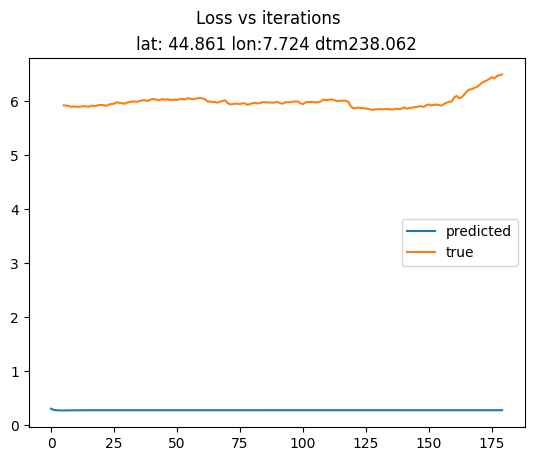

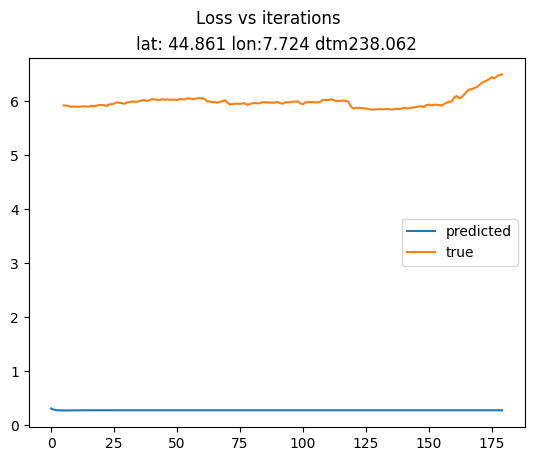

In [17]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

print('mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

for i in range(max_epochs):
    
    model.train(True)
    start_time = time.time()
    print(f"############### Training epoch {i} ###############")
    
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")
                
                x = x.to(device)
                x_mask = x_mask.to(device)
                z = z.to(device)
                weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                w = [w_values.to(device), weather_coords_batch.to(device)]
                y = y.to(device)
                y_mask = y_mask.to(device)
                
                optimizer.zero_grad()
                
                y_hat = model(x, z, w, x_mask)
                
                loss_data = masked_mse(y_hat,
                                  y,
                                  y_mask)
                
                print(f"Train data-loss: {loss}")
                
                # Control point generation
                time_cpoint = random.sample(range(x.shape[0]), 10)
                for aug_date_idx in range(len(time_cpoint)):
                    
                    x_cpoint = x[time_cpoint[aug_date_idx],:,:].expand(100,-1,-1)
                    x_mask_cpoint = x_mask[time_cpoint[aug_date_idx],:].expand(100,-1)
                    
                    z_cpoint = cpoint_generation(minX = ds.dtm_roi.x.min().values, maxX = ds.dtm_roi.x.max().values,
                                                minY = ds.dtm_roi.y.min().values, maxY = ds.dtm_roi.y.max().values,
                                                dtm = ds.dtm_roi,
                                                num_lon_point = 10,
                                                num_lat_point = 10)
                    
                    z_cpoint = torch.tensor(z_cpoint).to(device)
                    w_cpoint = w[time_cpoint[aug_date_idx],:,:,:,:].expand(100,-1,-1,-1,-1)
                
                    y_hat_cpoint = model(x_cpoint, z_cpoint, w_cpoint, x_mask_cpoint)
                    y_hat = torch.cat([y_hat, y_hat_cpoint], dim = 0)
                
                loss_pde = pde_loss_1d(y_hat)
                
                loss = loss_data + loss_pde
                    
                loss.backward()
                optimizer.step()
                
                metrics = {
                    "train_loss" : loss
                }
                wandb.log(metrics) 
                
                if batch_idx == 1:
                    break             
                
    end_time = time.time()
    exec_time = end_time-start_time

    wandb.log({"tr_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"training_pred":wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]),
                                                 y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })

    model_name = 'model_{}_{}.pt'.format(timestamp, i)    
    model_dir = dict_files["save_model_dir"]
    torch.save(model.state_dict(), f"{model_dir}/{model_name}") 

    print(f"############### Test epoch {i} ###############")
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    start_time = time.time()
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    # print('Batch mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    y_hat = model(x, z, w, x_mask)
                    # print('After predict mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    loss = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    print(f"Test loss: {loss}")

                    metrics = {
                        "test_loss" : loss
                    }

                    wandb.log(metrics)
                    
                    if batch_idx == 1:
                        break  
        
    end_time = time.time()
    exec_time = end_time-start_time
    wandb.log({"test_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"test_pred": wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]), y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })


wandb.finish()

print(f"Execution time: {end_time-start_time}s")

# Physics loss

In [ ]:
# grad function

In [11]:
def physics_loss(model: torch.nn.Module):
    control_points_x_ode = torch.linspace(-100, 100, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    control_points_y_ode = model(control_points_x_ode)
    ode_est = grad(control_points_y_ode, control_points_x_ode)[0]
    pde = 2*control_points_x_ode - ode_est
    
    # Metti temporal encoding in input? 
    pde = 
    pde_res = 
    
    return torch.mean(pde**2)

SyntaxError: invalid syntax (2927248471.py, line 8)

# Test plots

In [17]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]
    
if type(dict_files["test_split_p"]) is str:
    
    train_idx = int(ds.get_iloc_from_date(date_max= np.datetime64(dict_files["test_split_p"])))
    test_idx = int(max_ds_elems - train_idx)
else:
    test_split_p = dict_files["test_split_p"]
    train_split_p = 1 - test_split_p
    
    train_idx = int(max_ds_elems*train_split_p)
    test_idx = int(max_ds_elems*test_split_p)

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx,
                                                        train_idx + test_idx)

print(f"Traing size: {train_idx} - {ds.wtd_df.index.get_level_values(0)[train_idxs[-1]]}, Test size: {test_idx} - {ds.wtd_df.index.get_level_values(0)[test_idxs[-1]]}")

# Sampler 
if dict_files["random_sampler"] is True:
    train_sampler = RandomSampler(train_idxs)
else:
    train_sampler = SequentialSampler(train_idxs)
    
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=31,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=31,
                                            sampler=test_sampler)

Traing size: 192478 - 2017-12-31 00:00:00, Test size: 62342 - 2023-07-04 00:00:00


In [13]:
model_path = "/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models/model_20250116_115800.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

Continuous1DNN_idw(
  (cb_fc): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
  )
  (conv3d_stack): Sequential(
    (0): Conv3d(16, 64, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv3d(64, 64, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8

In [14]:
def masked_mse(y_hat, y, mask):
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

def masked_mae(y_hat, y, mask):
    return torch.sum(torch.abs((y_hat[mask]-y[mask])))  / torch.sum(mask)

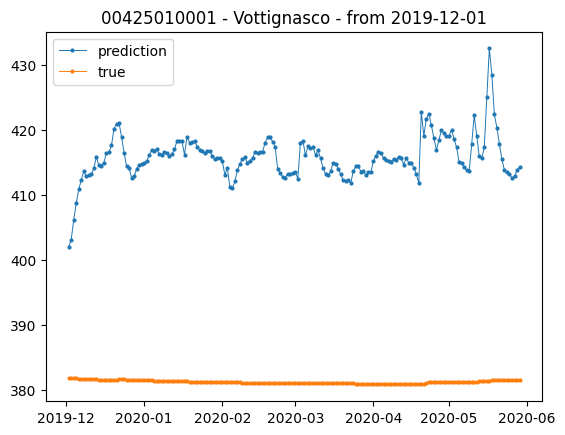

In [ ]:
plot_one_series(ds = ds, date_t0=np.datetime64("2019-12-01"), sensor=15, model = model, device = device,
                  print_plot = True)

In [22]:
sample_h, sample_wtd, dtm_denorm_downsampled = predict_map_points(ds, lon_point = 30, 
                 sample_date = np.datetime64("2019-12-01"),
                 model = model, device = device)

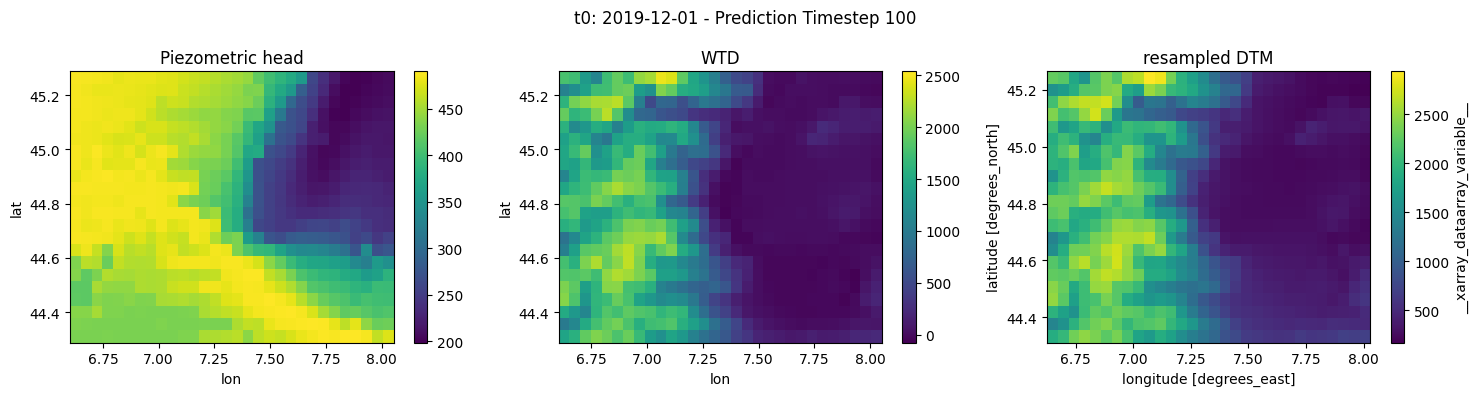

In [30]:
plot_one_map(sample_h, sample_wtd, dtm_denorm_downsampled, 
                 np.datetime64("2019-12-01"), pred_timestep = 100,
                 save_dir = None, 
                 print_plot = True)

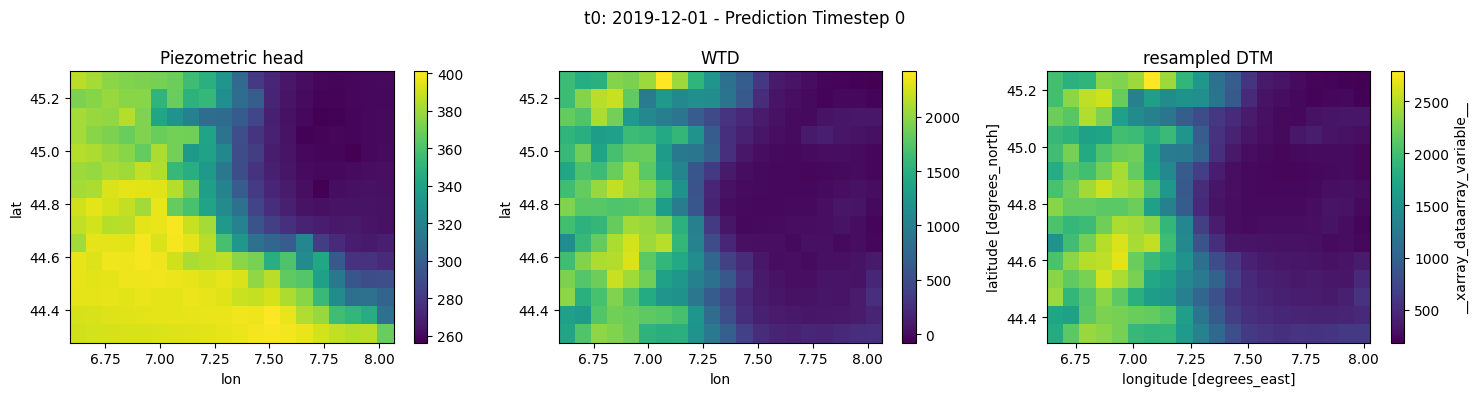

In [16]:
plot_one_map(ds = ds, sample_idx = 0,
             lon_point = 20, 
             sample_date = np.datetime64("2019-12-01"),
             pred_timestep = 50,
             model = model,
             device = device,
             save_dir = None, 
             print_plot = True)

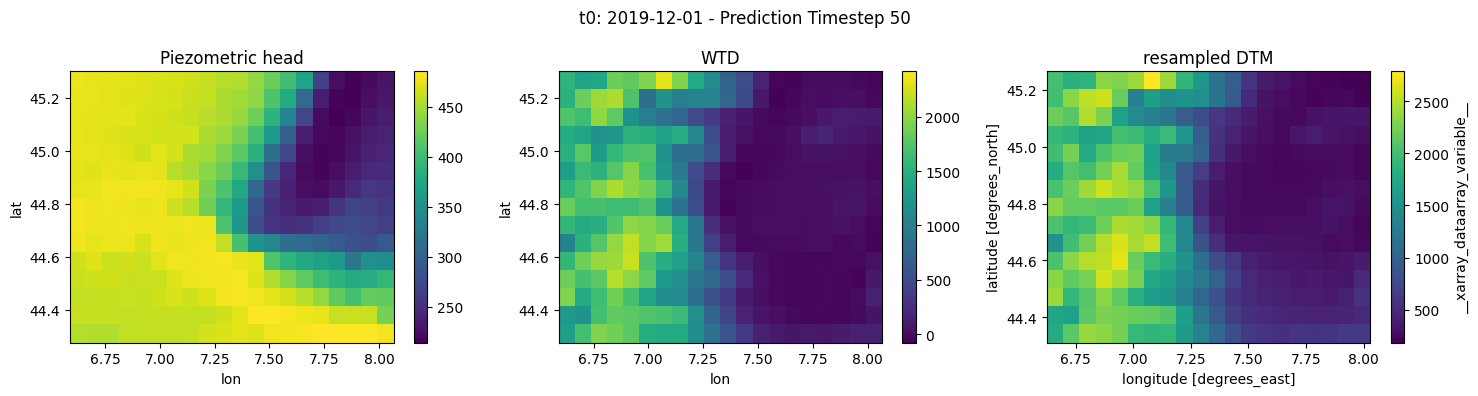

In [17]:
plot_one_map(ds = ds, sample_idx = 0,
             lon_point = 20, 
             sample_date = np.datetime64("2019-12-01"),
             pred_timestep = 50,
             model = model,
             device = device,
             save_dir = None, 
             print_plot = True)

In [14]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

y_list = []
y_hat_list = []
mse_list = []
mae_list = []

with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    #tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    
                    y_hat = model(x, z, w, x_mask)
                    # denormalize 
                    y_hat = (y_hat * ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]
                    y = (y * ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]
                    
                    y_list.append(y)
                    y_hat_list.append(y_hat)

                    mse = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    mse_list.append(mse)
                    
                    mae = masked_mae(y_hat,
                                  y,
                                  y_mask)
                    mae_list.append(mae)
                    
                    if batch_idx == 5:
                        break

  0%|          | 5/2012 [00:14<1:39:02,  2.96s/batch]


In [15]:
sample_day = 0

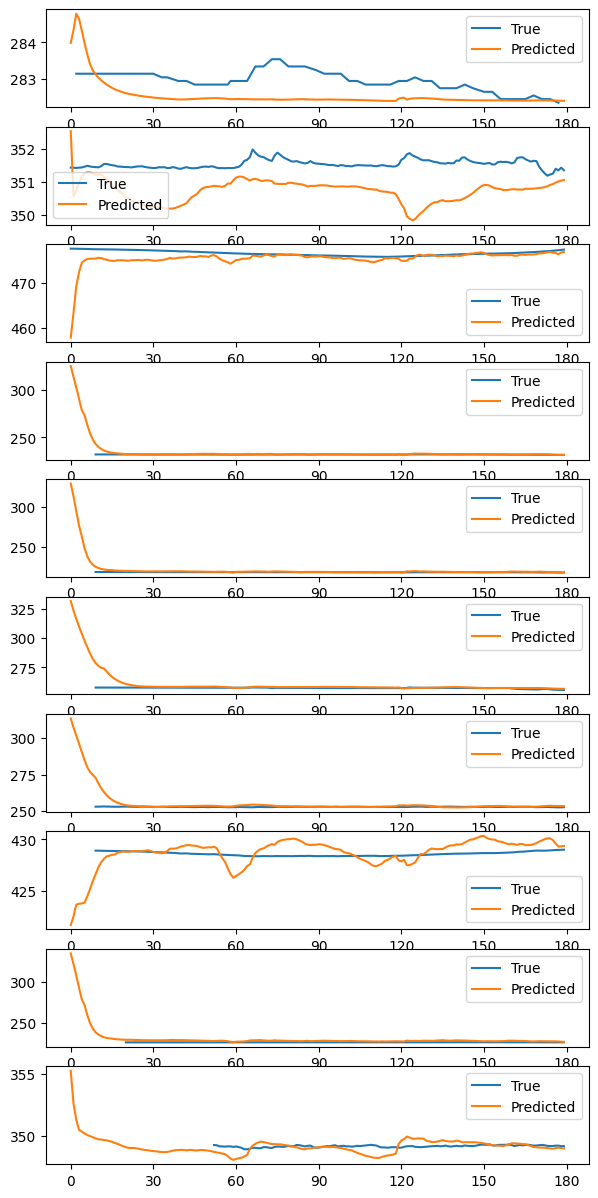

In [16]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10):
        y = y_list[sample_day][i, :].detach().numpy()
        y_idx = np.argwhere(~np.isnan(y))

        ax[i].plot(y_idx, y[y_idx], label = "True")
        ax[i].plot(np.arange(180), y_hat_list[sample_day][i, :].detach().numpy(), label = "Predicted")
        ax[i].set_xticks(np.arange(181, step = 30) )
        ax[i].legend()
        
plt.show()

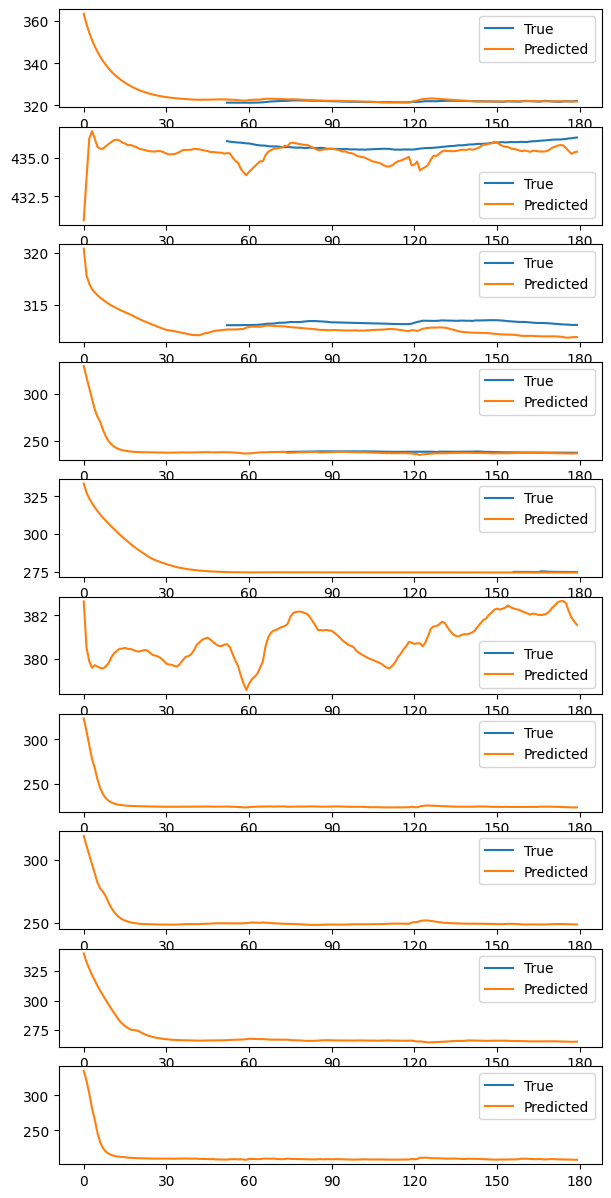

In [17]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10,20):
        y = y_list[sample_day][i, :].detach().numpy()
        y_idx = np.argwhere(~np.isnan(y))

        ax[i - 10].plot(y_idx, y[y_idx], label = "True")
        ax[i - 10].plot(np.arange(180), y_hat_list[sample_day][i, :].detach().numpy(), label = "Predicted")
        ax[i - 10].set_xticks(np.arange(181, step = 30) )
        ax[i - 10].legend()
        
plt.show()

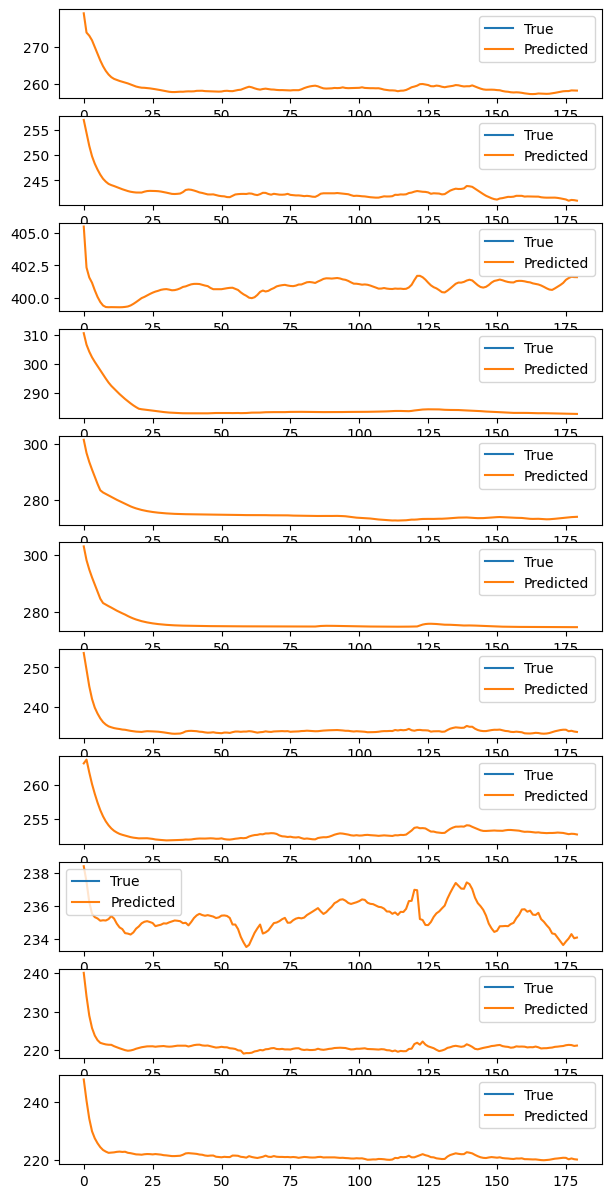

In [23]:
fig, ax = plt.subplots(11, figsize = (7,15))
for i in range(20,31):
        ax[i-20].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i-20].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i-20].legend()

In [ ]:
MAE = nn.L1Loss()
MSE = nn.MSELoss()

# Compute MAE
output_tensor = MAE(test_prediction, test_target)

# Compute RMSE
RMSE = MSE(test_prediction, test_target)
RMSE = torch.sqrt(RMSE)

print("MAE: ", MAE)
print("RSME: ", RMSE)

# Map predictions

In [12]:
def cpoint_generation(minX, maxX, minY, maxY, dtm,
                      mode = "even",
                      num_lon_point = 100,
                      num_lat_point = 100):
    
    if mode == "even":
        
        # create one-dimensional arrays for x and y
        x = np.linspace(minX, maxX, num_lon_point)
        y = np.linspace(minY, maxY, num_lat_point)[::-1]
        # create the mesh based on these arrays
        X, Y = np.meshgrid(x, y)
        coords = np.stack([Y, X], axis = -1)
        
        
    dtm_xy = dtm.sel(x = x, y = y,
                     method = "nearest").values
    
    coords = np.concat([coords, np.moveaxis(dtm_xy, 0, -1)], axis=-1)
    coords = coords.reshape(coords.shape[0]*coords.shape[1], coords.shape[2])
        
    return coords

In [13]:
sample_date = np.datetime64("2010-06-01")
sample_idx = ds.get_iloc_from_date(date_max = sample_date)

In [15]:
x = ds[sample_idx][0].unsqueeze(0)
z = ds[sample_idx][1].unsqueeze(0)
x_mask = ds[sample_idx][4].unsqueeze(0)

weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
weather_coords_batch = weather_coords.unsqueeze(0)

w = [ds[sample_idx][2].unsqueeze(0),
     weather_coords_batch]

In [16]:
lon_point = 30
lat_point = int(lon_point * 0.75)
total_cpoint = lat_point * lon_point
x_cpoint = x.expand(total_cpoint,-1,-1)
x_mask_cpoint = x_mask.expand(total_cpoint,-1)
                    
z_cpoint = cpoint_generation(minX = ds.dtm_roi.x.min().values, maxX = ds.dtm_roi.x.max().values,
                                                minY = ds.dtm_roi.y.min().values, maxY = ds.dtm_roi.y.max().values,
                                                dtm = (ds.dtm_roi *ds.norm_factors["dtm_std"]) + ds.norm_factors["dtm_mean"],
                                                num_lon_point = lon_point,
                                                num_lat_point = lat_point)

# normalization 
z_cpoint[:,0] = (z_cpoint[:,0] - ds.norm_factors["lat_mean"])/ds.norm_factors["lat_std"]
z_cpoint[:,1] = (z_cpoint[:,1] - ds.norm_factors["lon_mean"])/ds.norm_factors["lon_std"]
z_cpoint[:,2] = (z_cpoint[:,2] - ds.norm_factors["dtm_mean"].values)/ds.norm_factors["dtm_std"].values
                    
z_cpoint = torch.tensor(z_cpoint).to(torch.float32).to(device)
w_cpoint = [w[0].expand(total_cpoint,-1,-1,-1,-1),
            w[1].expand(total_cpoint,-1,-1,-1)]
                
y_hat_cpoint = model(x_cpoint, z_cpoint, w_cpoint, x_mask_cpoint)

In [17]:
from rasterio.enums import Resampling

dtm_denorm = (ds.dtm_roi *ds.norm_factors["dtm_std"]) + ds.norm_factors["dtm_mean"]

# downscaling dtm
#downscale_factor = 0.05
new_width = lon_point #int(dtm_roi.rio.width * downscale_factor)
new_height = lat_point #int(dtm_roi.rio.height * downscale_factor)

dtm_denorm_downsampled = dtm_denorm.rio.reproject(
    dtm_denorm.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

In [18]:
# varia prima long (6.7 in senso crescente)
# poi varia lat (in senso crescente)

# primo elemento (alto sx è quindi) 

In [19]:
z_cpoint[:,0] = (z_cpoint[:,0]*ds.norm_factors["lat_std"]) +  ds.norm_factors["lat_mean"]
z_cpoint[:,1] = (z_cpoint[:,1]*ds.norm_factors["lon_std"]) + ds.norm_factors["lon_mean"]

In [20]:
h_pred = y_hat_cpoint.reshape(lat_point,lon_point,180).detach().numpy()
h_pred = (h_pred* ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]

sample_h = xarray.DataArray(data = h_pred,
                               coords = dict(
                                        lon=("lon", z_cpoint[:,1].unique().detach().numpy()),
                                        lat=("lat", z_cpoint[:,0].unique().detach().numpy()[::-1]),
                                        time=np.arange(180)),
                               dims = ["lat", "lon", "time"]
                               )

wtd_pred = []
for timestep in range(180):
     wtd_pred.append(dtm_denorm_downsampled.values.squeeze() - sample_h[:,:,timestep].values)

wtd_pred = np.stack(wtd_pred, axis = -1)
sample_wtd = xarray.DataArray(data = wtd_pred,
                               coords = dict(
                                        lon=("lon", z_cpoint[:,1].unique().detach().numpy()),
                                        lat=("lat", z_cpoint[:,0].unique().detach().numpy()[::-1]),
                                        time=np.arange(180)),
                               dims = ["lat", "lon", "time"]
                               )

In [21]:
sample_wtd.min()

<xarray.DataArray ()> Size: 8B
array(-63.28211219)

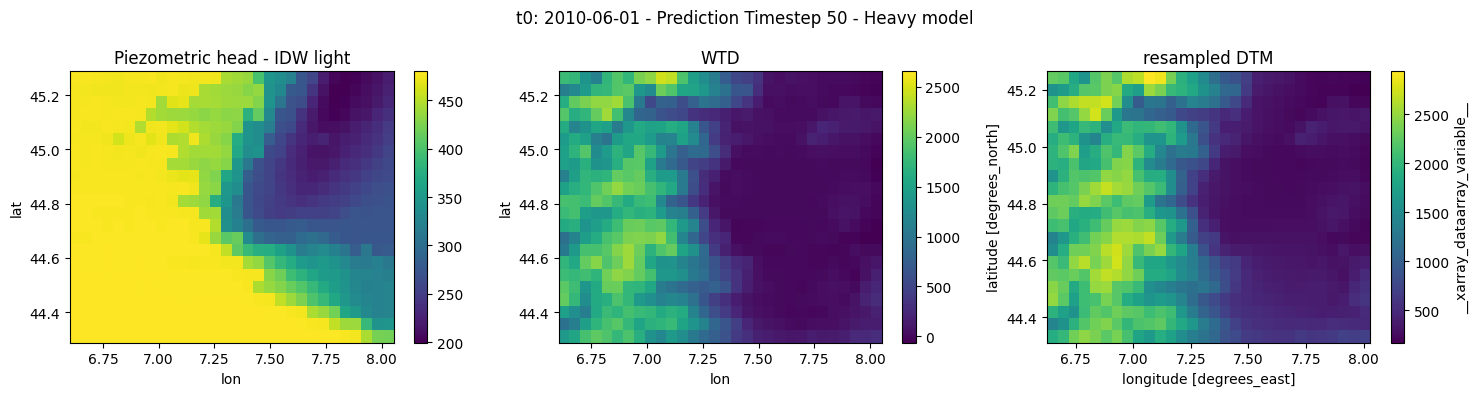

In [31]:
pred_timestep = 50
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep} - Heavy model")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head - IDW light")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")

ax[2].set_ylabel("lat")
ax[2].set_xlabel("lon")


plt.tight_layout()

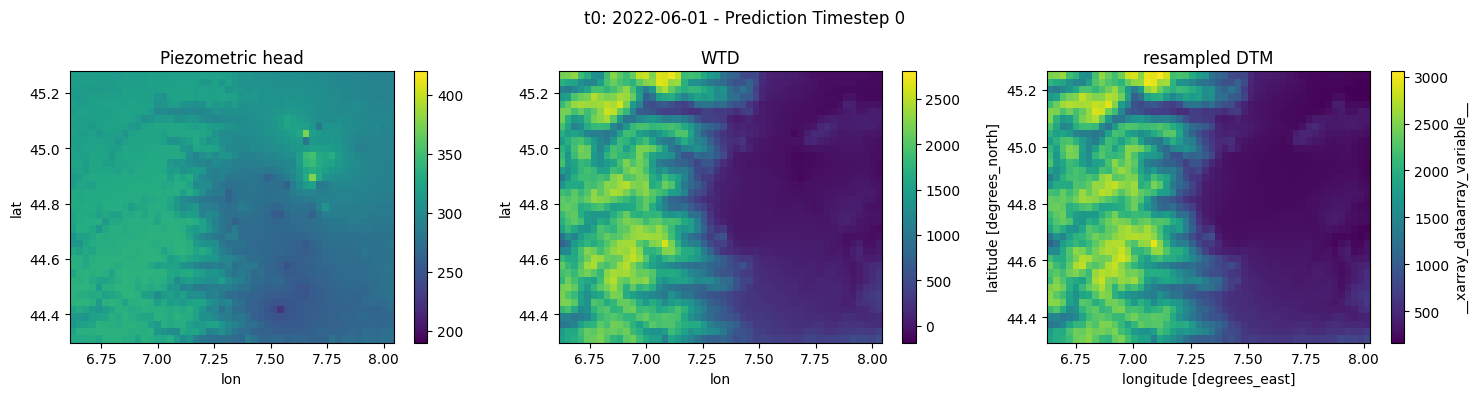

In [45]:
pred_timestep = 0
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0], vmin = 190, vmax = 420)
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")

plt.tight_layout()

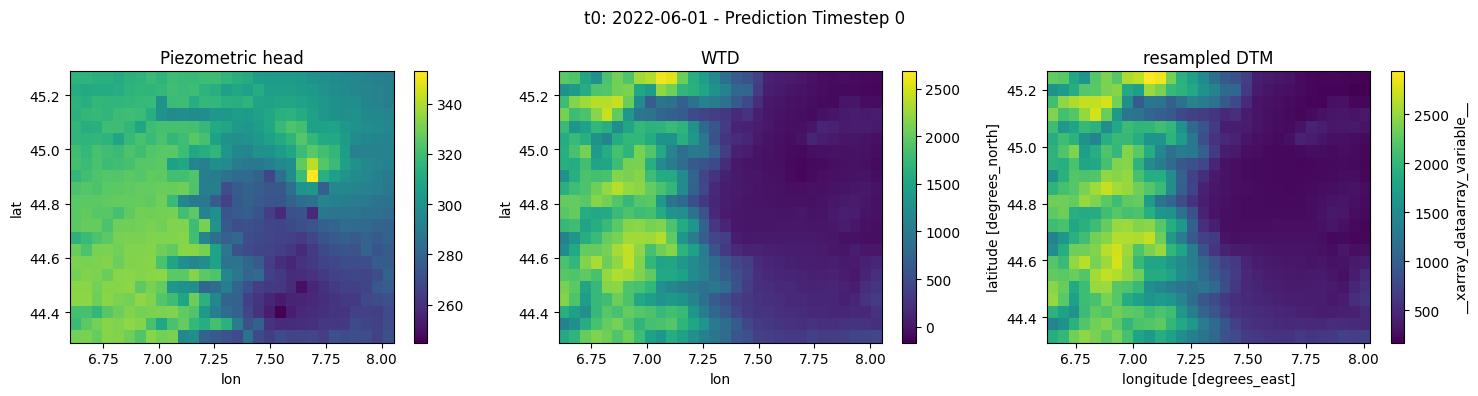

In [27]:
pred_timestep = 0
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")

plt.tight_layout()

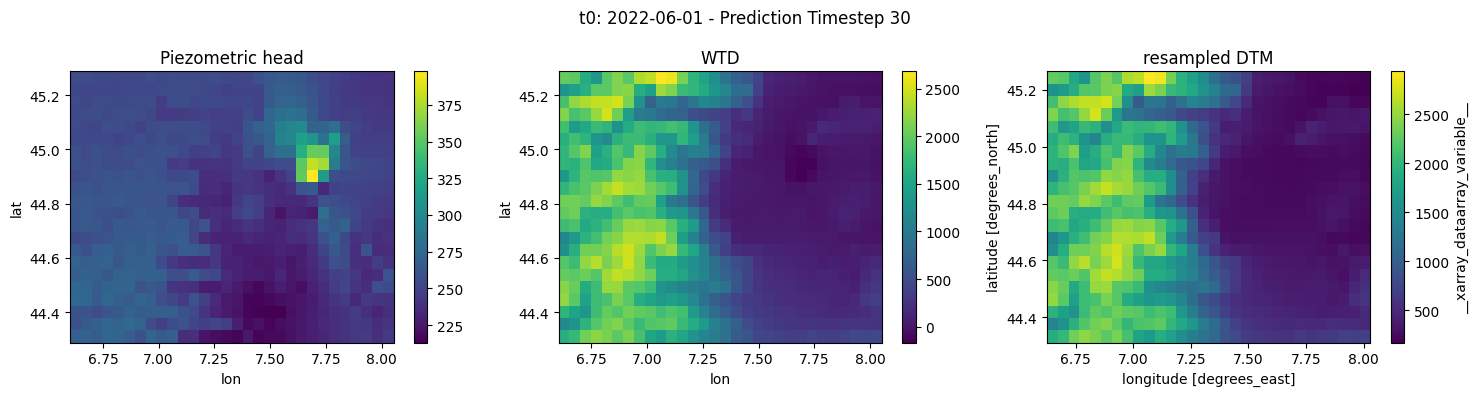

In [28]:
pred_timestep = 30
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")
plt.tight_layout()

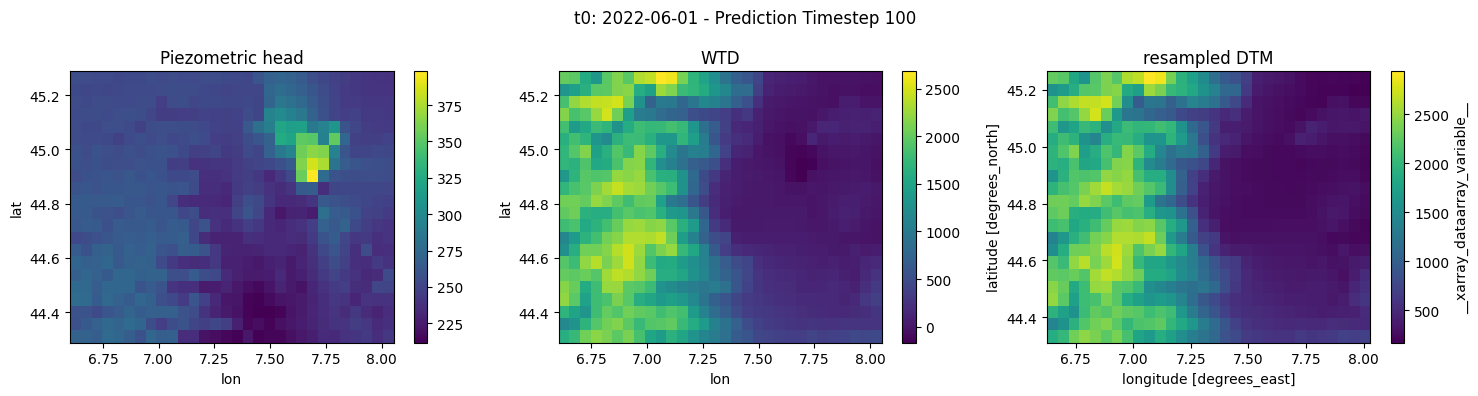

In [29]:
pred_timestep = 100
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")
plt.tight_layout()

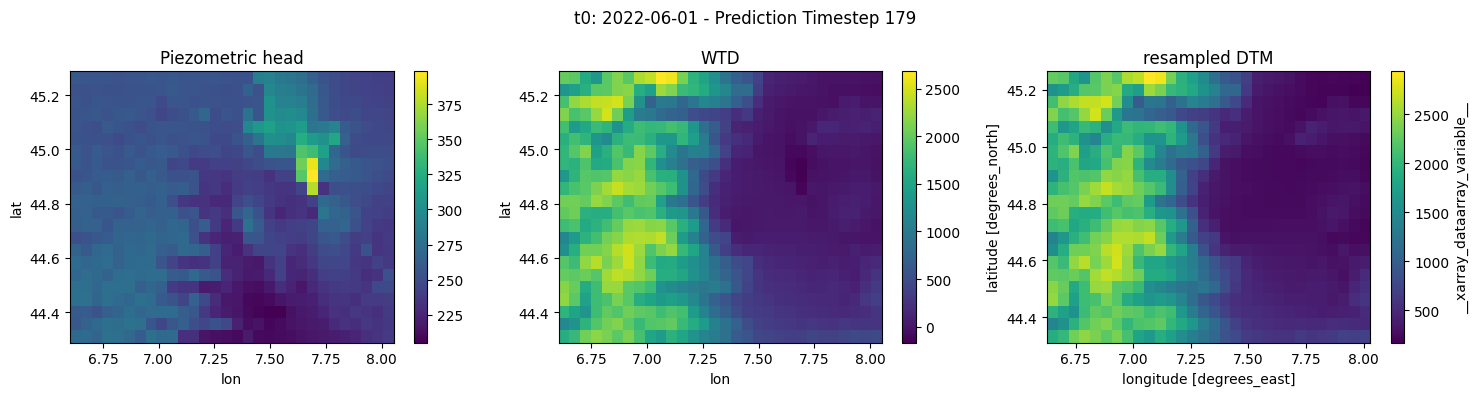

In [30]:
pred_timestep = 179
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")
plt.tight_layout()

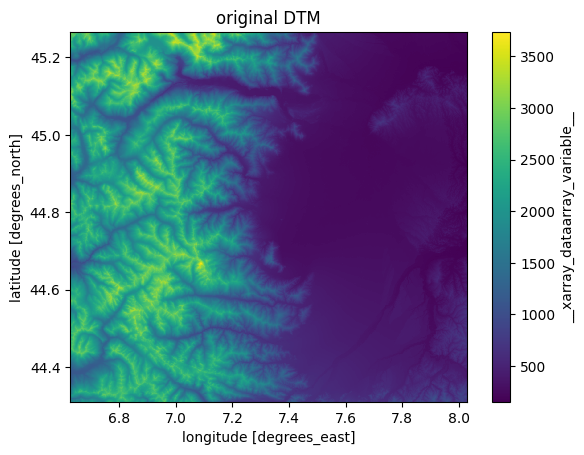

In [166]:
dtm_denorm.plot()
plt.title("original DTM")
plt.show()

In [141]:
sample_pred = sample_h.to_dataset(name = "h")

In [143]:
sample_pred = sample_pred.assign(wtd = sample_wtd)

In [169]:
sample_pred

<xarray.Dataset> Size: 866kB
Dimensions:  (lon: 20, lat: 15, time: 180)
Coordinates:
  * lon      (lon) float32 80B 6.627 6.7 6.774 6.848 ... 7.808 7.882 7.955 8.029
  * lat      (lat) float32 60B 44.31 44.38 44.45 44.52 ... 45.13 45.2 45.26
  * time     (time) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
Data variables:
    h        (lat, lon, time) float64 432kB 333.8 326.9 319.0 ... 256.6 256.4
    wtd      (lat, lon, time) float64 432kB -1.678e+03 -1.685e+03 ... -369.1